# 1. Preprocessing and EDA

Using CMIP sst datasets from Tello et al.

## Imports

In [1]:
# IPython extension to reload modules before executing user code.
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.patches as patches
import os
import pandas as pd
import xarray as xr
import calendar
import scipy.stats

from pandas.plotting import lag_plot
from datetime import datetime

import utils
import utilities.graph_utils as graph_utils

In [3]:
CMIP6_FOLDER = 'datasets/CMIP6/CMIP6_regridded/w_cellarea'
HadISST_FOLDER = 'datasets/HadISST/HadISST_regridded'
GODAS_FOLDER = 'datasets/GODAS/GODAS_regridded'

## Global variables

In [4]:
# climatology base period
BASE_PERIOD_START = '1961-01-01'
BASE_PERIOD_END = '1990-12-31'
display(BASE_PERIOD_START, BASE_PERIOD_END)

BASE_PERIOD_START_yr = BASE_PERIOD_START.split("-")[0]
BASE_PERIOD_END_yr = BASE_PERIOD_END.split("-")[0]
display(BASE_PERIOD_START_yr, BASE_PERIOD_END_yr)

'1961-01-01'

'1990-12-31'

'1961'

'1990'

In [5]:
EDA_IMG_FOLDER = 'img/EDA/'
EDA_IMG_FOLDER

'img/EDA/'

### Select dates for Train-Val-Test split (used only for distribution display)

In [6]:
# train_start_date = '1851-01-01'
train_start_date = '1871-01-01'
train_end_date = '1970-12-31'

val_start_date = '1976-01-01'
val_end_date =   '1990-12-31'

test_start_date = '1996-01-01'
test_end_date =   '2010-12-31'

print(f"Train start and end dates: {train_start_date} to {train_end_date}")
print(f"Val start and end dates: {val_start_date} to {val_end_date}")
print(f"Test start and end dates: {test_start_date} to {test_end_date}")

Train start and end dates: 1871-01-01 to 1970-12-31
Val start and end dates: 1976-01-01 to 1990-12-31
Test start and end dates: 1996-01-01 to 2010-12-31


In [7]:
# extract year part of the dates
train_start_year = train_start_date.split("-")[0]
train_end_year   = train_end_date.split("-")[0]

val_start_year = val_start_date.split("-")[0]
val_end_year   = val_end_date.split("-")[0]

test_start_year = test_start_date.split("-")[0]
test_end_year   = test_end_date.split("-")[0]

print(f"Train start and end years: {train_start_year}-{train_end_year}")
print(f"Train start and end years: {val_start_year}-{val_end_year}")
print(f"Train start and end years: {test_start_year}-{test_end_year}")

Train start and end years: 1871-1970
Train start and end years: 1976-1990
Train start and end years: 1996-2010


# Load CMIP6 model outputs

In [8]:
# create dictionary for reggridded data
cmip_dict = dict()

print("Loading following regridded CMIP6 datasets from disk:\n")
for filename in os.listdir(CMIP6_FOLDER):
    filepath = os.path.join(CMIP6_FOLDER, filename)

    # if file exist on disk, load it
    if os.path.isfile(filepath):
        print(f"• {filename}")
        cmip_dict[filename] = xr.open_dataset(filepath)

Loading following regridded CMIP6 datasets from disk:

• CMIP.MRI.MRI-ESM2-0.historical.Omon.gn_cellarea.regridded.nc
• CMIP.MIROC.MIROC6.historical.Omon.gn_cellarea.regridded.nc
• CMIP.BCC.BCC-ESM1.historical.Omon.gn_cellarea.regridded.nc
• CMIP.CAS.FGOALS-f3-L.historical.Omon.gn_cellarea.regridded.nc
• CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.gn_cellarea.regridded.nc


In [9]:
for key in sorted(cmip_dict.keys()):
    print(f"{key}")
    ds = cmip_dict[key]    
    print(f"•  Institution: {ds.attrs['institution']}")
    print(f"•  Creation date: {ds.attrs['creation_date'].split("T")[0]}")
    print(f"•  Time: From {ds['time'][0].values.astype('datetime64[D]')} to {ds['time'][-1].values.astype('datetime64[D]')}")
    print(f"•  Dimensions: {dict(ds.sizes)}")
    print(f"•  {ds.data_vars}")
    print()
    # display(ds)

CMIP.BCC.BCC-ESM1.historical.Omon.gn_cellarea.regridded.nc
•  Institution: Beijing Climate Center, Beijing 100081, China
•  Creation date: 2018-11-29
•  Time: From 1850-01-16 to 2014-12-16
•  Dimensions: {'member_id': 1, 'dcpp_init_year': 1, 'time': 1980, 'lat': 180, 'lon': 360, 'bnds': 2}
•  Data variables:
    tos      (member_id, dcpp_init_year, time, lat, lon) float32 513MB ...

CMIP.CAS.FGOALS-f3-L.historical.Omon.gn_cellarea.regridded.nc
•  Institution: Chinese Academy of Sciences, Beijing 100029, China
•  Creation date: 2019-10-07
•  Time: From 1850-01-16 to 2014-12-16
•  Dimensions: {'member_id': 1, 'dcpp_init_year': 1, 'time': 1980, 'lat': 180, 'lon': 360, 'bnds': 2}
•  Data variables:
    tos      (member_id, dcpp_init_year, time, lat, lon) float32 513MB ...

CMIP.MIROC.MIROC6.historical.Omon.gn_cellarea.regridded.nc
•  Institution: JAMSTEC (Japan Agency for Marine-Earth Science and Technology, Kanagawa 236-0001, Japan), AORI (Atmosphere and Ocean Research Institute, The Univ

# Ground truth
To test the model performance, the Hadley Centre Sea Ice and Sea Surface Temperature data set (HadISST) _(TODO: replace with Global Ocean Data Assimilation System (GODAS) reanalysis)_ was used for theperiod 1990–2022 as we take these values to be our ground truth. We leave a 5-year gap between the training/validation period and the testing period to avoid any impact of oceanic memory, similarly to ref. 37 . Anomalieswere computed for all the variables used in this study and were coarsened to a 5◦ × 5◦ resolution in order toimprove model performance by enhancing the spatial signature of major features.
??????



#### Load data from Hadley Centre Sea Ice and Sea Surface Temperature data set (HadISST)

In [10]:
new_filename = "OBS.HAD.HADISST.regridded.nc"
savepath = HadISST_FOLDER + '/regridded'
os.makedirs(savepath, exist_ok=True) 
nc_out = os.path.join(savepath, new_filename)

print(f"{new_filename} already exist in {savepath}. Loading it from disk...\n")
hadisst_ds_regrid = xr.open_dataset(nc_out)

OBS.HAD.HADISST.regridded.nc already exist in datasets/HadISST/HadISST_regridded/regridded. Loading it from disk...



In [11]:
print(f"•  Institution: {hadisst_ds_regrid.attrs['institution']}")
# print(f"•  Creation date: {hadisst_ds.attrs['creation_date'].split("T")[0]}")
print(f"•  Time: From {hadisst_ds_regrid['time'][0].values.astype('datetime64[D]')} to {hadisst_ds_regrid['time'][-1].values.astype('datetime64[D]')}")
print(f"•  Dimensions: {dict(hadisst_ds_regrid.sizes)}")
print(f"•  {hadisst_ds_regrid.data_vars}")
print()

•  Institution: Met Office Hadley Centre
•  Time: From 1870-01-16 to 2024-02-15
•  Dimensions: {'time': 1850, 'lat': 180, 'lon': 360}
•  Data variables:
    tos      (time, lat, lon) float32 480MB ...



In [12]:
# replace masked values (-1000) with nan
hadisst_ds_regrid['tos'] = hadisst_ds_regrid['tos'].where(hadisst_ds_regrid['tos'] != -1000, np.nan)

# GODAS

In [13]:
# create new file name
new_filename = "ASSIM.NOAA.GODAS.pottmp.5m.C.regridded.nc"
savepath = GODAS_FOLDER + '/regridded'
nc_out = os.path.join(savepath, new_filename)

# if regridded file already exist on disk, load it
if os.path.isfile(nc_out):
    print(f"{new_filename} already exist in {savepath}. Loading it from disk...\n")
    godas_ds_regrid = xr.open_dataset(nc_out)
else:    
    print(f'{nc_out} could not be found...')

godas_ds_regrid

ASSIM.NOAA.GODAS.pottmp.5m.C.regridded.nc already exist in datasets/GODAS/GODAS_regridded/regridded. Loading it from disk...



<xarray.Dataset> Size: 138MB
Dimensions:  (time: 534, lat: 180, lon: 360)
Coordinates:
  * time     (time) datetime64[ns] 4kB 1980-01-01 1980-02-01 ... 2024-06-01
  * lat      (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 86.5 87.5 88.5 89.5
  * lon      (lon) float64 3kB 0.5 1.5 2.5 3.5 4.5 ... 356.5 357.5 358.5 359.5
Data variables:
    tos      (time, lat, lon) float32 138MB ...

In [14]:
# print(f"•  Institution: {godas_ds_regrid.attrs['institution']}")
# print(f"•  Creation date: {hadisst_ds.attrs['creation_date'].split("T")[0]}")
print(f"•  Time: From {godas_ds_regrid['time'][0].values.astype('datetime64[D]')} to {godas_ds_regrid['time'][-1].values.astype('datetime64[D]')}")
print(f"•  Dimensions: {dict(godas_ds_regrid.sizes)}")
print(f"•  {godas_ds_regrid.data_vars}")
print()

•  Time: From 1980-01-01 to 2024-06-01
•  Dimensions: {'time': 534, 'lat': 180, 'lon': 360}
•  Data variables:
    tos      (time, lat, lon) float32 138MB ...



# EDA

## Plot temperatures from different models on map

In [15]:
cmip_dict.keys()

dict_keys(['CMIP.MRI.MRI-ESM2-0.historical.Omon.gn_cellarea.regridded.nc', 'CMIP.MIROC.MIROC6.historical.Omon.gn_cellarea.regridded.nc', 'CMIP.BCC.BCC-ESM1.historical.Omon.gn_cellarea.regridded.nc', 'CMIP.CAS.FGOALS-f3-L.historical.Omon.gn_cellarea.regridded.nc', 'CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.gn_cellarea.regridded.nc'])

In [16]:
# merge hadisst dataset with cmip dict
all_dict = cmip_dict.copy()
all_dict["OBS.HAD.HADISST.regridded.nc"] = hadisst_ds_regrid
all_dict["ASSIM.NOAA.GODAS.pottmp.5m.C.regridded.nc"] = godas_ds_regrid
list(all_dict.keys())

['CMIP.MRI.MRI-ESM2-0.historical.Omon.gn_cellarea.regridded.nc',
 'CMIP.MIROC.MIROC6.historical.Omon.gn_cellarea.regridded.nc',
 'CMIP.BCC.BCC-ESM1.historical.Omon.gn_cellarea.regridded.nc',
 'CMIP.CAS.FGOALS-f3-L.historical.Omon.gn_cellarea.regridded.nc',
 'CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.gn_cellarea.regridded.nc',
 'OBS.HAD.HADISST.regridded.nc',
 'ASSIM.NOAA.GODAS.pottmp.5m.C.regridded.nc']

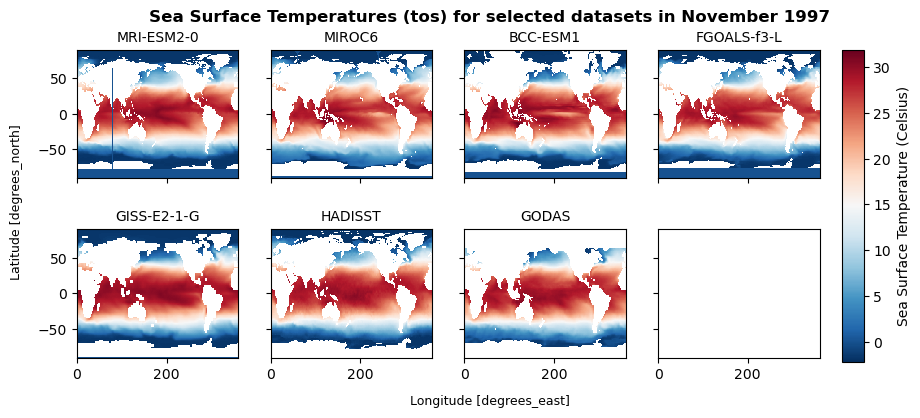

In [17]:
# time_sel = "1950-10-16"
time_sel = "1997-11-16"

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(11, 4), sharex=True, sharey=True)

# get min and max tos values across all datasets for shared color bar
# tos_min, tos_max = -30, +30
tos_min, tos_max = np.inf, -np.inf
for (name, ds), ax in zip(all_dict.items(), axs.flat):
    data = ds['tos'].sel(time=time_sel, method='nearest')
    tos_min = min(tos_min, data.min())
    tos_max = max(tos_max, data.max())


# Iterate over datasets and their respective axes
for (name, ds), ax in zip(all_dict.items(), axs.flat):
    data = ds['tos'].sel(time=time_sel, method='nearest')

    im = data.plot(ax=ax, add_colorbar=False, cmap='RdBu_r', vmin=tos_min, vmax=tos_max)
    
    # Set title to the dataset's name
    ax.set_title(name.split(".")[2], fontsize=10)

    # Accessing axis labels
    xlabel = ax.get_xlabel()
    ylabel = ax.get_ylabel()
    ax.set(xlabel=None, ylabel=None)

    

# Set title
time_split = time_sel.split("-")
month =  int(time_split[1])
year = time_split[0]
fig.suptitle(f"Sea Surface Temperatures (tos) for selected datasets in {calendar.month_name[month]} {year}", fontweight="bold")

# Create a shared colorbar for the entire figure
fig.subplots_adjust(right=0.8, hspace=0.4) # Adjust spacing between subplots, as well as right margin for the colorbar
cbar_ax = fig.add_axes([0.82, 0.10, 0.02, 0.78])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Sea Surface Temperature (Celsius)')  # Customize label as needed


fig.text(0.5, 0.0, xlabel, ha='center', va='center', fontsize=9)
fig.text(0.07, 0.5, ylabel, ha='center', va='center', rotation='vertical', fontsize=9)

plt.show()

# Preprocessing

In [18]:
list(all_dict.keys())

['CMIP.MRI.MRI-ESM2-0.historical.Omon.gn_cellarea.regridded.nc',
 'CMIP.MIROC.MIROC6.historical.Omon.gn_cellarea.regridded.nc',
 'CMIP.BCC.BCC-ESM1.historical.Omon.gn_cellarea.regridded.nc',
 'CMIP.CAS.FGOALS-f3-L.historical.Omon.gn_cellarea.regridded.nc',
 'CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.gn_cellarea.regridded.nc',
 'OBS.HAD.HADISST.regridded.nc',
 'ASSIM.NOAA.GODAS.pottmp.5m.C.regridded.nc']

### Compute mean SST along time dimension

In [19]:
ds = all_dict['OBS.HAD.HADISST.regridded.nc']

ds_mean = ds['tos'].mean(dim='time')

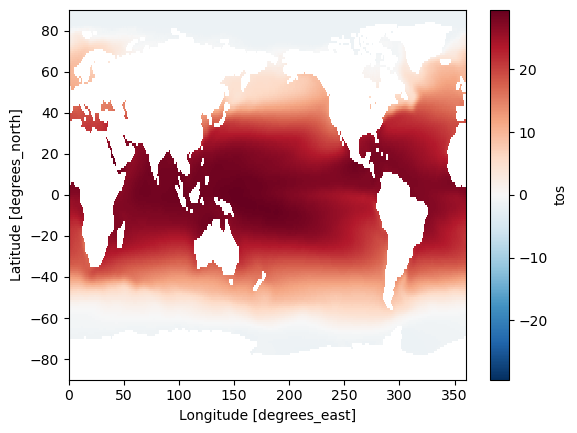

In [20]:
ds_mean.plot()

### Focus on 1 grid-cell

Mark grid cell at coordinate [0N, 225E]

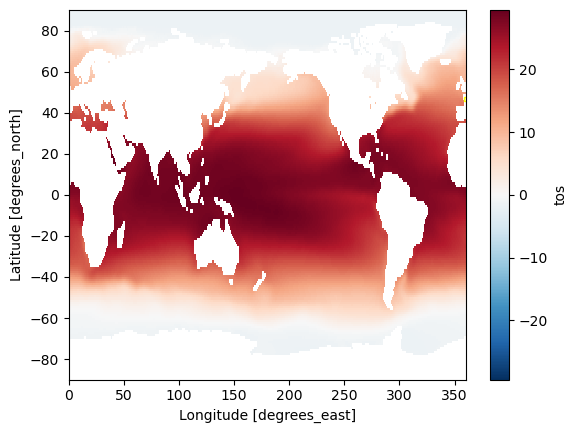

In [21]:
# Select a specific cell's latitude and longitude

# middle of ENSO 3.4 location
# lat_point = 0.5
# lon_point = 225.5

# west coast of France
lat_point = 45.5
lon_point = 358.5

cell_size = 2

# Create a figure and axes
fig, ax = plt.subplots()

# Plot the data
ds_mean.plot(ax=ax)

# Create a rectangle patch for the grid cell borders
rect = patches.Rectangle(xy=(lon_point, lat_point), width=cell_size, height=cell_size, linewidth=1, edgecolor='yellow', facecolor='none')

# Add the patch to plot
ax.add_patch(rect)

plt.show()

#### Compute and plot Time series components

![Time Series components](img/timeseries_components.png)\
_Timeseries is combination of Trend, Seasonality and Residual error or random noise. (Source: [Exploring Time Series Data: Unveiling Trends, Seasonality, and Residuals](https://medium.com/@venujkvenk/exploring-time-series-data-unveiling-trends-seasonality-and-residuals-5cace823aff1))_

#### Plot time series at that grid cell

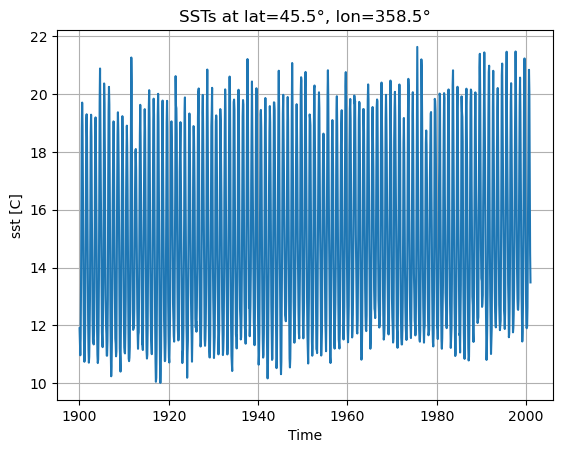

In [22]:
slice_start, slice_end = '1900-01-01', '2000-12-31'
tos1 = ds['tos'].sel(lon=lon_point, 
                     lat=lat_point, 
                     time=slice(slice_start, slice_end))
tos1.plot()
plt.title(f"SSTs at lat={lat_point}°, lon={lon_point}°")
plt.grid()
plt.show()

#### Manual Seasonal adjustment or deseasonalization

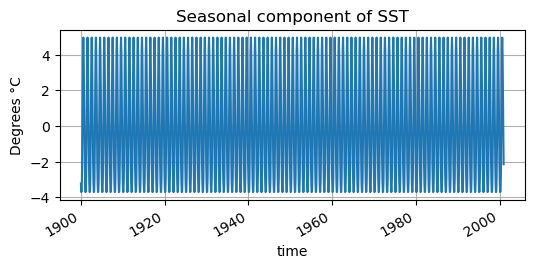

In [23]:
frequency = 12
fig, ax = plt.subplots(figsize=(6, 2.5))

tos1_slice = tos1.sel(time=slice(slice_start, slice_end))

# Convert to a pandas Series with datetime index
tos1_series = tos1_slice.to_series()

# Calculate the seasonal indices (average for each month)
monthly_avg = tos1_series.groupby(tos1_series.index.month).mean()
# display("monthly average: ", monthly_avg)

# Calculate the seasonal component
nb_years = int(len(tos1_series)/frequency)

# np.tile constructs an array by repeating the first argument the number of times given by reps.
seasonal_component = np.tile(monthly_avg, reps=nb_years)

# map back to time series
seasonal_component_ts = pd.Series(seasonal_component, index=tos1_series.index)

# subtracting the mean to get mean 0
seasonal = seasonal_component_ts - seasonal_component_ts.mean()
seasonal.plot(ax=ax)

plt.ylabel("Degrees °C")
plt.title("Seasonal component of SST")
plt.grid()
plt.show()

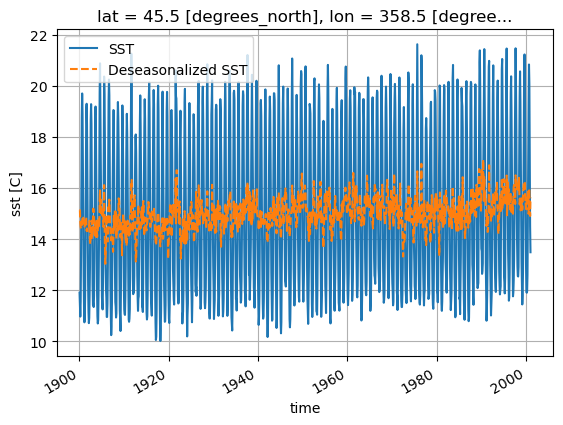

In [24]:
tos1_slice.plot(label='SST')

# Calculate the Seasonal Mean (mean for each month across years)
deseasonalized_data = tos1_series - seasonal
deseasonalized_data.plot(linestyle='dashed', label='Deseasonalized SST')
plt.legend()
plt.grid()


#### Manual Detrending

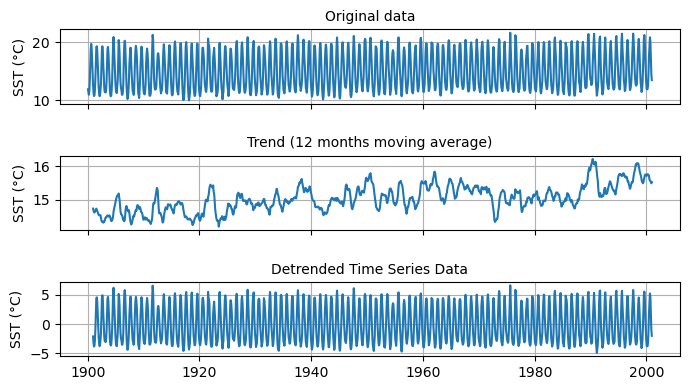

In [25]:
# Define the window size for the moving average
window_size = 12

# Calculate the moving average
moving_average = tos1_series.rolling(window_size).mean()

# Detrend the time series by subtracting the moving average
detrended_data = tos1_series[window_size - 1:] - moving_average


fig, axs = plt.subplots(3, figsize=(7, 4), sharex=True, sharey=False)

axs[0].plot(tos1_series, label=f'Original data', linestyle='-')
axs[0].set_title(f'Original data', fontsize=10)
axs[0].set_ylabel('SST (°C)')
axs[0].grid(True)
# axs[0].legend()


axs[1].plot(moving_average, label=f'Trend', linestyle='-')
axs[1].set_title(f'Trend ({window_size} months moving average)', fontsize=10)
axs[1].set_ylabel('SST (°C)')
axs[1].grid(True)
# axs[1].legend()

axs[2].plot(detrended_data, label='Detrended Data', linestyle='-')
axs[2].set_title('Detrended Time Series Data', fontsize=10)
# axs[2].set_xlabel('Time')
axs[2].set_ylabel('SST (°C)')
axs[2].grid(True)
# axs[2].legend()

plt.tight_layout(h_pad=2, w_pad=None)
plt.show()

#### Statsmodel Seasonal decomposition 
Seasonal decomposition using moving averages.


In an additive model, the observations are modeled as a linear combination of the seasonal component, the trend component, and the error. \
(Source: [Forecastegy Deseasonalizing Time Series Data With Python](https://forecastegy.com/posts/deseasonalizing-time-series-data-python/))

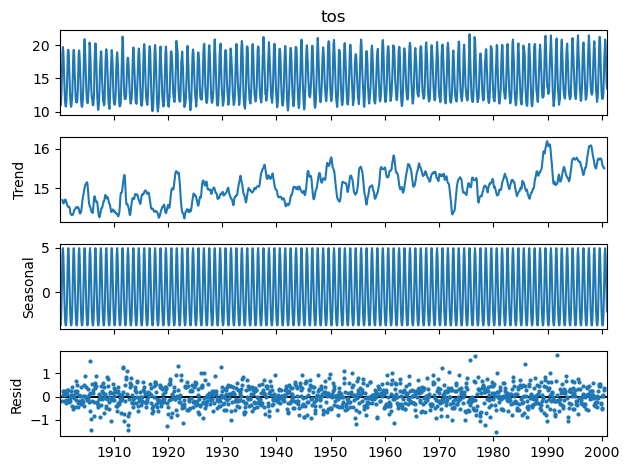

In [26]:
from statsmodels.tsa.seasonal import seasonal_decompose

tos1_slice = tos1.sel(time=slice(slice_start, slice_end))

# Make sure it's a pandas Series with datetime index
tos1_series = tos1_slice.to_series()

decomposition = seasonal_decompose(tos1_series, model='additive', period=12)
fig = decomposition.plot() 

# change marker size on Residual plot
ax = fig.axes[-1]
for line in ax.get_lines():
    line.set_markersize(2) 
    
plt.show()

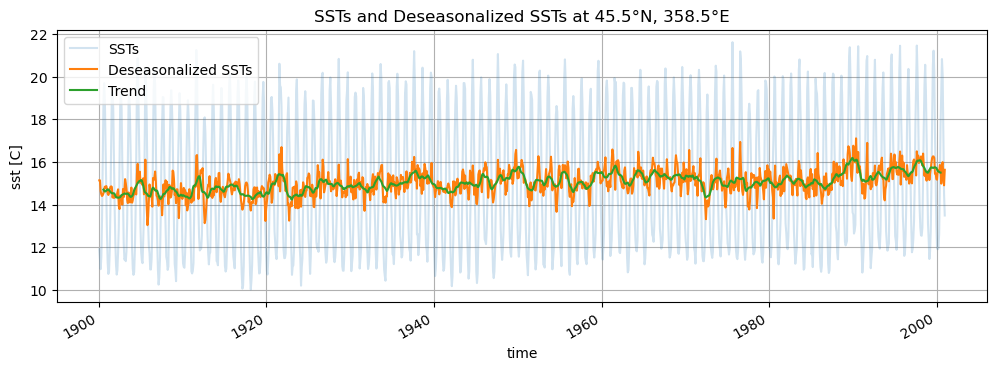

In [27]:
deseason_tos1_slice = tos1_series - decomposition.seasonal

fig, ax = plt.subplots(1, figsize=(12, 4))

tos1_slice.plot(label='SSTs', alpha=0.2)
deseason_tos1_slice.plot(linestyle='-', label='Deseasonalized SSTs')
decomposition.trend.plot(label='Trend')

plt.title(f"SSTs and Deseasonalized SSTs at {lat_point}°N, {lon_point}°E")
plt.legend()
plt.grid()
plt.show()

### ACF and PACF: Deciphering Dependencies:

- ACF measures the correlation between a time series and its past values at various lags, while 
- PACF takes into account the direct relationships, excluding indirect influences. (source: https://medium.com/@venujkvenk/exploring-time-series-data-unveiling-trends-seasonality-and-residuals-5cace823aff1)

Statsmodel doc:
- `sm.graphics.tsa.plot_acf`: Plot the autocorrelation function. Plots lags on the horizontal and the correlations on vertical axis.
- `sm.graphics.tsa.plot_pacf`: Plot the partial autocorrelation function.

In [28]:
# import statsmodels.api as sm

# max_lags = 48
# # Create subplots for ACF and PACF
# fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(8, 4))

# # Plot ACF
# sm.graphics.tsa.plot_acf(tos1_slice, lags=48, ax=ax1)
# ax1.set_title('Autocorrelation Function (ACF)')


# # Plot PACF
# sm.graphics.tsa.plot_pacf(tos1_slice, lags=48, ax=ax2)
# ax2.set_title('Partial Autocorrelation Function (PACF)')


# # plot yearly vertical bar
# for x in range(0, max_lags, 12):
#     ax1.axvline(x, color='purple', linestyle='dotted', linewidth=1, label=f'yearly')
#     ax2.axvline(x, color='purple', linestyle='dotted', linewidth=1, label=f'yearly')

# plt.tight_layout()
# plt.show()

## Mean Sea Surface Temperatures

Minimum mean temperature across all datasets: -1.90
Maximum mean temperature across all datasets: 30.55


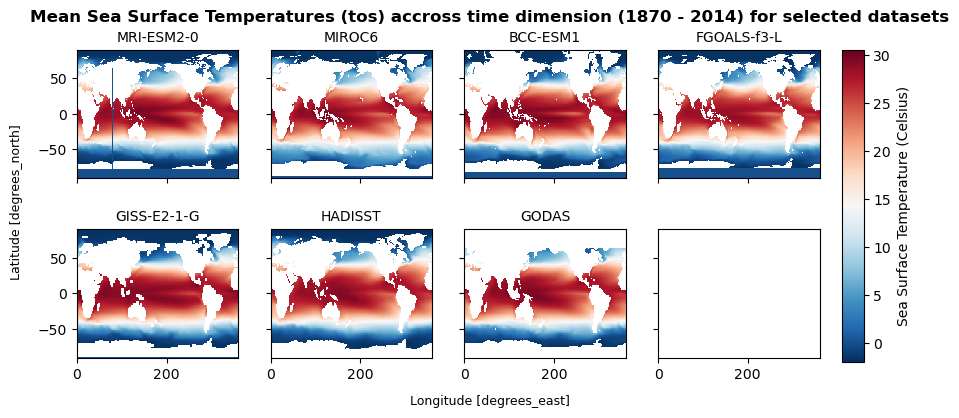

In [29]:
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(11, 4), sharex=True, sharey=True)

# get min and max mean tos values across all datasets for shared color bar
# tos_min, tos_max = -30, +30
tos_min, tos_max = np.inf, -np.inf
for (name, ds), ax in zip(all_dict.items(), axs.flat):
    data = ds['tos'].mean(dim='time')
    tos_min = min(tos_min, data.min())
    tos_max = max(tos_max, data.max())

    
    # start_year = ds['time'][0].values.astype('datetime64[Y]')
    # end_year = ds['time'][-1].values.astype('datetime64[Y]')
    # print(start_year)
    # print(end_year)


print(f"Minimum mean temperature across all datasets: {tos_min.item():.2f}")
print(f"Maximum mean temperature across all datasets: {tos_max.item():.2f}")

# Iterate over datasets and their respective axes
for (name, ds), ax in zip(all_dict.items(), axs.flat):
    data = ds['tos'].sel(time=slice('1870-01-01', '2014-12-31')).mean(dim='time')

    im = data.plot(ax=ax, add_colorbar=False, cmap='RdBu_r', vmin=tos_min, vmax=tos_max)
    
    # Set title to the dataset's name
    ax.set_title(name.split(".")[2], fontsize=10)

    # Accessing axis labels
    xlabel = ax.get_xlabel()
    ylabel = ax.get_ylabel()
    ax.set(xlabel=None, ylabel=None)

    

# Set title
time_split = time_sel.split("-")
month =  int(time_split[1])
year = time_split[0]
fig.suptitle(f"Mean Sea Surface Temperatures (tos) accross time dimension (1870 - 2014) for selected datasets", fontweight="bold")

# Create a shared colorbar for the entire figure
fig.subplots_adjust(right=0.8, hspace=0.4) # Adjust spacing between subplots, as well as right margin for the colorbar
cbar_ax = fig.add_axes([0.82, 0.10, 0.02, 0.78])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Sea Surface Temperature (Celsius)')  


fig.text(0.5, 0.0, xlabel, ha='center', va='center', fontsize=9)
fig.text(0.07, 0.5, ylabel, ha='center', va='center', rotation='vertical', fontsize=9)

plt.show()

## Compute and Plot Temperature Anomalies


1. Compute Climatology - Monthly Gridded Climate Normals: For every spatial coordinate, compute the monthly mean SST over the time period of BASE_PERIOD_START_yr-{BASE_PERIOD_END_yr}.

2. Compute the tos anomalies subtract this mean from all data of the same month

[(tutorial)](https://comptools.climatematch.io/tutorials/W1D1_ClimateSystemOverview/student/W1D1_Tutorial6.html)

### Compute Monthly Climatology

In [30]:
tos_climatology_dict = {}

# Iterate over cmip datasets and their respective axes
for (key, ds), ax in zip(all_dict.items(), axs.flat):
    print(f"Computing SST monthly climatology for {key} over the period of {BASE_PERIOD_START_yr} to {BASE_PERIOD_END_yr}")
    
    # compute SST monthly climatology for the period of {BASE_PERIOD_START_yr} to {BASE_PERIOD_END_yr}
    tos_climatology = ds['tos'].sel(time=slice(BASE_PERIOD_START, BASE_PERIOD_END)).groupby("time.month").mean("time")
    # display(tos_climatology)

    # Assign the tos anomaly DataArray to a new Dataset
    tos_climatology_ds = tos_climatology.to_dataset(name='tos_climatology') 
    tos_climatology_dict[key] = tos_climatology_ds

Computing SST monthly climatology for CMIP.MRI.MRI-ESM2-0.historical.Omon.gn_cellarea.regridded.nc over the period of 1961 to 1990
Computing SST monthly climatology for CMIP.MIROC.MIROC6.historical.Omon.gn_cellarea.regridded.nc over the period of 1961 to 1990
Computing SST monthly climatology for CMIP.BCC.BCC-ESM1.historical.Omon.gn_cellarea.regridded.nc over the period of 1961 to 1990
Computing SST monthly climatology for CMIP.CAS.FGOALS-f3-L.historical.Omon.gn_cellarea.regridded.nc over the period of 1961 to 1990
Computing SST monthly climatology for CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.gn_cellarea.regridded.nc over the period of 1961 to 1990
Computing SST monthly climatology for OBS.HAD.HADISST.regridded.nc over the period of 1961 to 1990
Computing SST monthly climatology for ASSIM.NOAA.GODAS.pottmp.5m.C.regridded.nc over the period of 1961 to 1990


### Plot monthly climatology per month for all models

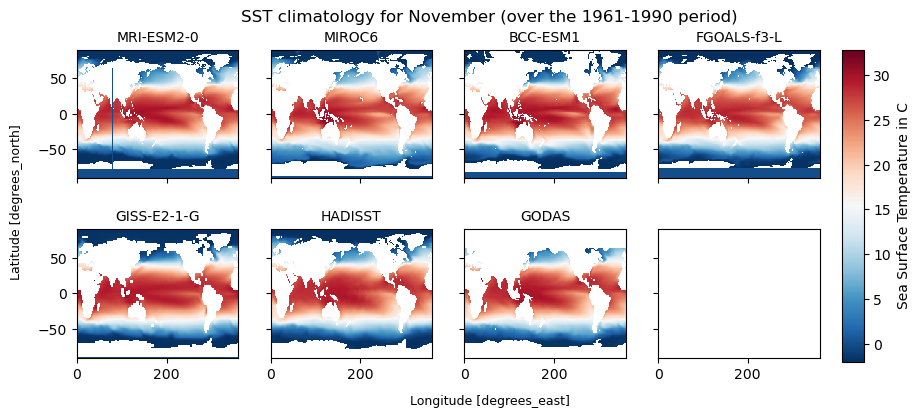

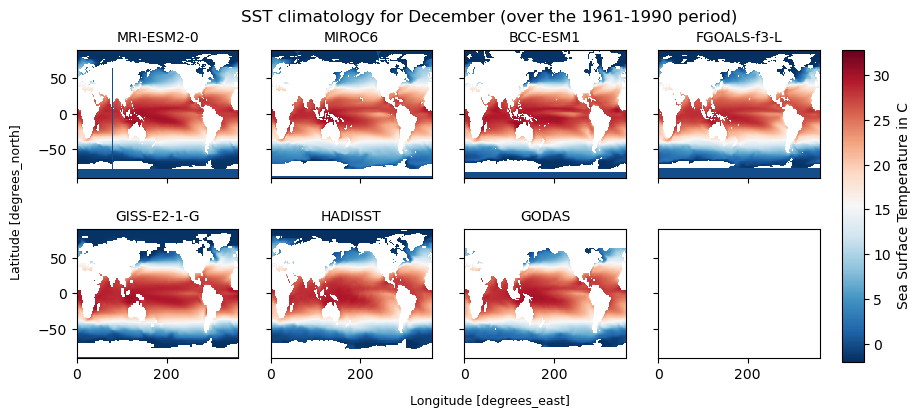

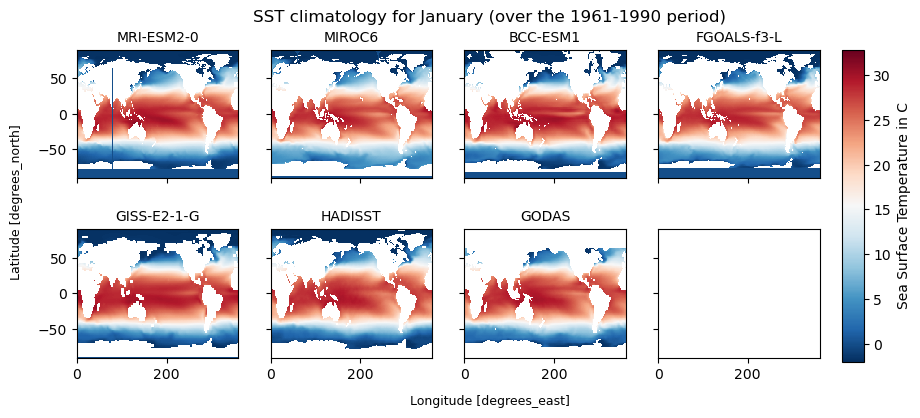

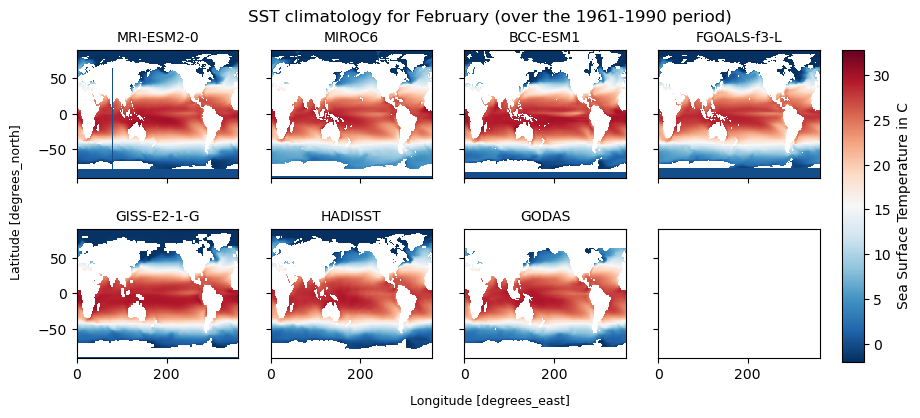

In [31]:
# iterate over the 12 months 
tos_min, tos_max = np.inf, -np.inf
months_to_iterate_on = [11,12,1,2] # nov, dec, jan, feb
    
# for month in range(1, 12):    
for month in months_to_iterate_on:    
       
    # get min and max tos values across all datasets for each month
    for key, ds in tos_climatology_dict.items():    
        data = ds['tos_climatology'].sel(month=month)
        tos_min = min(tos_min, data.min())
        tos_max = max(tos_max, data.max())
        
    # since we want the colorbar to be symetrical around zero, we need to take the maximum abs value and use it for min and max
    # abs_tos_max = max(abs(tos_min), abs(tos_max))



# for month in range(1, 12):   
for month in months_to_iterate_on: 
    
    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(11, 4), sharex=True, sharey=True)

    # interate over the cmip model datasets
    for (name, ds), ax in zip(tos_climatology_dict.items(), axs.flat):
        

        data = ds['tos_climatology'].sel(month=month)
        # im = data.plot(ax=ax, add_colorbar=False, cmap='RdBu_r')

        im = data.plot(ax=ax, add_colorbar=False, cmap='RdBu_r', vmin=tos_min, vmax=tos_max)
        
        # Set title to the dataset's name
        ax.set_title(name.split(".")[2], fontsize=10)
    
        # Accessing axis labels
        xlabel = ax.get_xlabel()
        ylabel = ax.get_ylabel()
        ax.set(xlabel=None, ylabel=None)
    
        
    # Set title
    fig.suptitle(f"SST climatology for {calendar.month_name[month]} (over the {BASE_PERIOD_START_yr}-{BASE_PERIOD_END_yr} period)")
    
    # Create a shared colorbar for the entire figure
    fig.subplots_adjust(right=0.8, hspace=0.4) # Adjust spacing between subplots, as well as right margin for the colorbar
    cbar_ax = fig.add_axes([0.82, 0.10, 0.02, 0.78])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Sea Surface Temperature in C')
    
    fig.text(0.5, 0.0, xlabel, ha='center', va='center', fontsize=9)
    fig.text(0.07, 0.5, ylabel, ha='center', va='center', rotation='vertical', fontsize=9)
    
    plt.show()

### Plot monthly climatology per model for each month

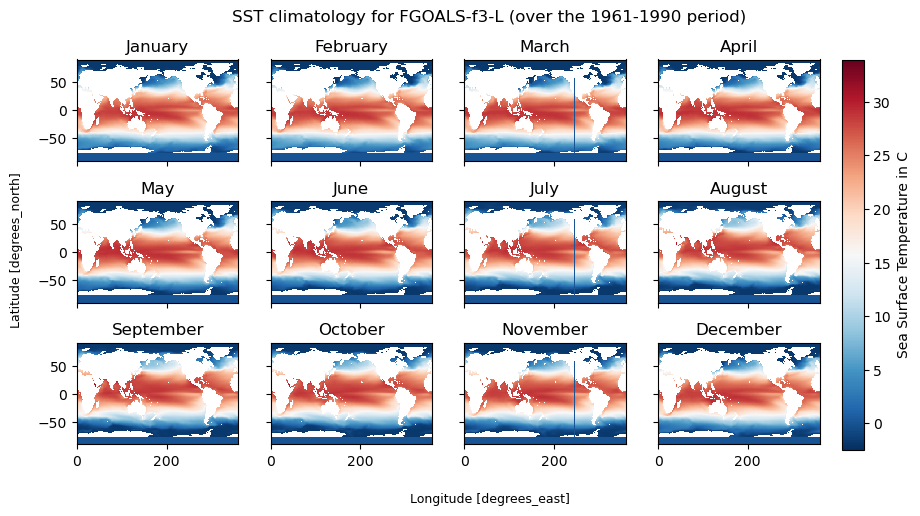

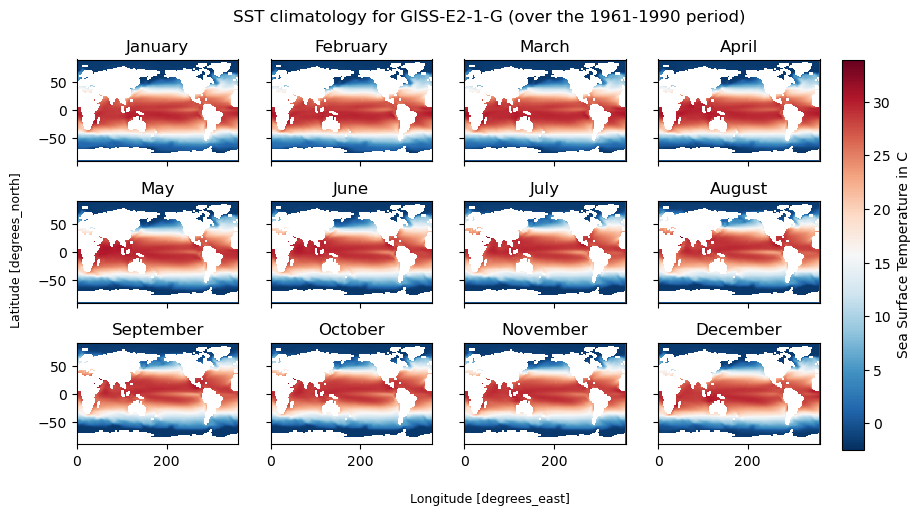

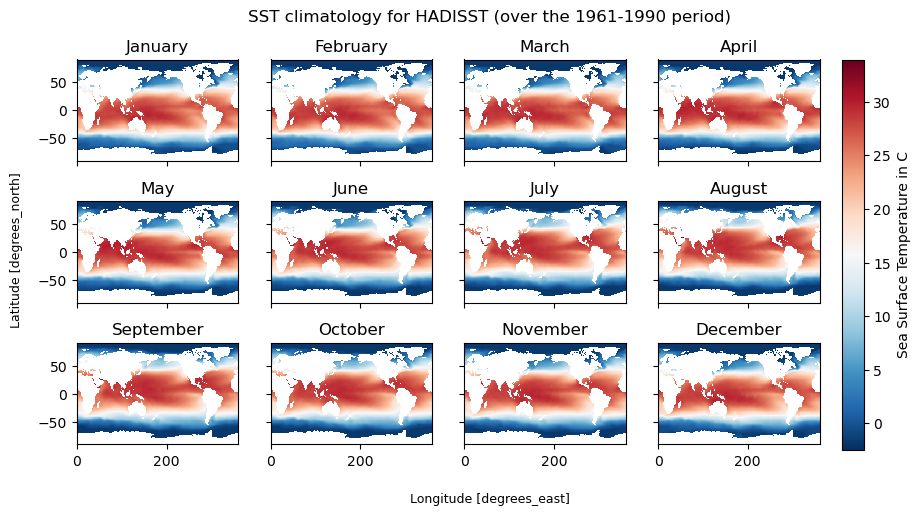

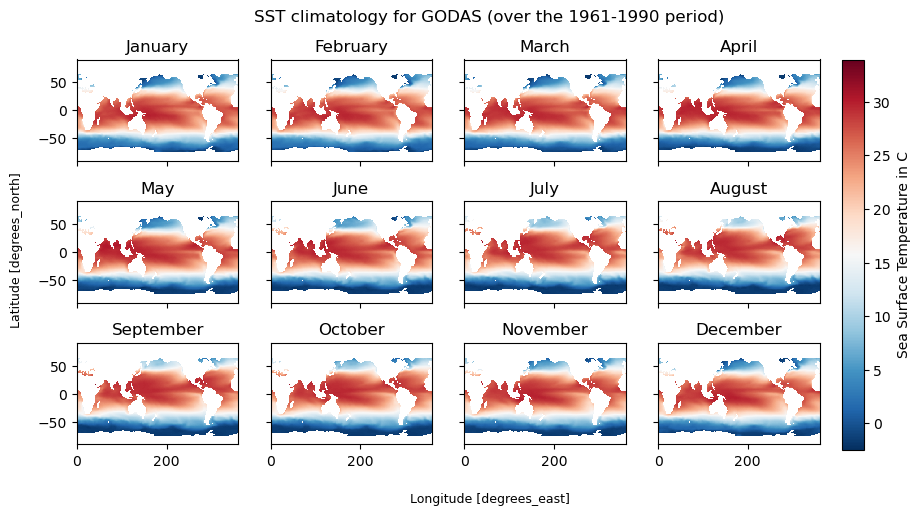

In [32]:
min_lat, max_lat = -50, 50
min_lon, max_lon = 100, 300

# min_lat, max_lat = 0, 60
# min_lon, max_lon = 240, 359

# iterate over the 12 months 
tos_min, tos_max = np.inf, -np.inf
tos_climatology_items_list = list(tos_climatology_dict.items())[-4:]

for month in range(1, 12):    
       
    # get min and max tos values across all datasets for each month
    for key, ds in tos_climatology_items_list:    
        data = ds['tos_climatology'].sel(month=month)
        tos_min = min(tos_min, data.min())
        tos_max = max(tos_max, data.max())
        
    # since we want the colorbar to be symetrical around zero, we need to take the maximum abs value and use it for min and max
    # abs_tos_max = max(abs(tos_min), abs(tos_max))



# interate over the cmip model datasets
for key, ds in tos_climatology_items_list:

    fig, axs = plt.subplots(nrows=3, ncols=4, figsize=(11, 5), sharex=True, sharey=True)

    for month, ax in zip(range(1, 13), axs.flat):    
        
        data = ds['tos_climatology'].sel(
            month=month,
            # lat=slice(min_lat, max_lat),
            # lon=slice(min_lon, max_lon)
        )
        # im = data.plot(ax=ax, add_colorbar=False, cmap='RdBu_r')

        im = data.plot(ax=ax, add_colorbar=False, cmap='RdBu_r', vmin=tos_min, vmax=tos_max)
        
        # Set title to the dataset's name
        ax.set_title(calendar.month_name[month])
    
        # Accessing axis labels
        xlabel = ax.get_xlabel()
        ylabel = ax.get_ylabel()
        ax.set(xlabel=None, ylabel=None)
    
        
    # Set title
    fig.suptitle(f"SST climatology for {key.split(".")[2]} (over the {BASE_PERIOD_START_yr}-{BASE_PERIOD_END_yr} period)")
    
    # Create a shared colorbar for the entire figure
    fig.subplots_adjust(right=0.8, hspace=0.4) # Adjust spacing between subplots, as well as right margin for the colorbar
    cbar_ax = fig.add_axes([0.82, 0.10, 0.02, 0.78])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Sea Surface Temperature in C')  
    
    fig.text(0.5, 0.0, xlabel, ha='center', va='center', fontsize=9)
    fig.text(0.07, 0.5, ylabel, ha='center', va='center', rotation='vertical', fontsize=9)
    
    plt.show()

### Compute monthly anomalies from climatology baseline

In [33]:
list(all_dict.keys())

['CMIP.MRI.MRI-ESM2-0.historical.Omon.gn_cellarea.regridded.nc',
 'CMIP.MIROC.MIROC6.historical.Omon.gn_cellarea.regridded.nc',
 'CMIP.BCC.BCC-ESM1.historical.Omon.gn_cellarea.regridded.nc',
 'CMIP.CAS.FGOALS-f3-L.historical.Omon.gn_cellarea.regridded.nc',
 'CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.gn_cellarea.regridded.nc',
 'OBS.HAD.HADISST.regridded.nc',
 'ASSIM.NOAA.GODAS.pottmp.5m.C.regridded.nc']

#### Compute monthly anomalies for a 1x1 degrees grid

In [34]:
tos_anom_1m_dict = dict()

for key, ds in all_dict.items():

    new_filename = key.replace("regridded", "regridded_tos_anom_1m")
    print(new_filename)
    if key.startswith("CMIP"):
        savepath = 'datasets/CMIP6/CMIP6_regridded/anom_1m/'
    elif key.startswith("OBS"):
        savepath = 'datasets/HadISST/HadISST_regridded/anom_1m/'
    elif key.startswith("ASSIM.NOAA"):
        savepath = 'datasets/GODAS/GODAS_regridded/anom_1m/'
    else:
        pritn("Unknown filename")
    
    os.makedirs(savepath, exist_ok=True) 
    nc_out = os.path.join(savepath, new_filename)

    # if anomalies file already exist on disk, load it
    if os.path.isfile(nc_out):
        print(f"{new_filename} already exist in {savepath}. Loading it...")
        tos_anom_1m_dict[new_filename] = xr.open_dataset(nc_out) # Store Dataset in dictionary 
        continue

    print(f"Computing TOS anomalies for {key}")

    # compute SST monthly climatology for the period of {BASE_PERIOD_START_yr} to {BASE_PERIOD_END_yr}
    tos_climatology = ds['tos'].sel(time=slice(BASE_PERIOD_START, BASE_PERIOD_END)).groupby("time.month").mean("time")
    # print(tos_climatology)
    
    # compute the tos anomalies subtract this mean from all data of the same month
    tos_anom_1m = ds['tos'].groupby("time.month")  - tos_climatology 

    # Assign the tos anomaly DataArray to a new Dataset
    tos_anom_1m_ds = tos_anom_1m.to_dataset(name='tos_anom_1m') 
    
    # Save Dataset to disk
    tos_anom_1m_ds.to_netcdf(nc_out)
    print('file written: {}\n'.format(nc_out))
    
    # Store Dataset in dictionary 
    tos_anom_1m_dict[new_filename] = tos_anom_1m_ds

CMIP.MRI.MRI-ESM2-0.historical.Omon.gn_cellarea.regridded_tos_anom_1m.nc
CMIP.MRI.MRI-ESM2-0.historical.Omon.gn_cellarea.regridded_tos_anom_1m.nc already exist in datasets/CMIP6/CMIP6_regridded/anom_1m/. Loading it...
CMIP.MIROC.MIROC6.historical.Omon.gn_cellarea.regridded_tos_anom_1m.nc
CMIP.MIROC.MIROC6.historical.Omon.gn_cellarea.regridded_tos_anom_1m.nc already exist in datasets/CMIP6/CMIP6_regridded/anom_1m/. Loading it...
CMIP.BCC.BCC-ESM1.historical.Omon.gn_cellarea.regridded_tos_anom_1m.nc
CMIP.BCC.BCC-ESM1.historical.Omon.gn_cellarea.regridded_tos_anom_1m.nc already exist in datasets/CMIP6/CMIP6_regridded/anom_1m/. Loading it...
CMIP.CAS.FGOALS-f3-L.historical.Omon.gn_cellarea.regridded_tos_anom_1m.nc
CMIP.CAS.FGOALS-f3-L.historical.Omon.gn_cellarea.regridded_tos_anom_1m.nc already exist in datasets/CMIP6/CMIP6_regridded/anom_1m/. Loading it...
CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.gn_cellarea.regridded_tos_anom_1m.nc
CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.gn_cellarea

In [35]:
list(tos_anom_1m_dict.keys())

['CMIP.MRI.MRI-ESM2-0.historical.Omon.gn_cellarea.regridded_tos_anom_1m.nc',
 'CMIP.MIROC.MIROC6.historical.Omon.gn_cellarea.regridded_tos_anom_1m.nc',
 'CMIP.BCC.BCC-ESM1.historical.Omon.gn_cellarea.regridded_tos_anom_1m.nc',
 'CMIP.CAS.FGOALS-f3-L.historical.Omon.gn_cellarea.regridded_tos_anom_1m.nc',
 'CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.gn_cellarea.regridded_tos_anom_1m.nc',
 'OBS.HAD.HADISST.regridded_tos_anom_1m.nc',
 'ASSIM.NOAA.GODAS.pottmp.5m.C.regridded_tos_anom_1m.nc']

##### Plot anomalies distribution

In [36]:
# # check that all datasets have same first and last date and lon/lat coordinates
# for (name, ds), ax in zip(tos_anom_1m_dict.items(), axs.flat):
#     data = ds['tos_anom_1m'].sel(time=slice(train_start_date, test_end_date))

#     print(name)
#     # check if all datasets have same first and last date
#     first_date = pd.to_datetime(test.time[0].values)
#     last_date = pd.to_datetime(test.time[-1].values)
#     formatted_first_date = first_date.strftime('%Y-%m-%d')
#     formatted_last_date = last_date.strftime('%Y-%m-%d')
#     print(formatted_date, formatted_last_date)

#     # check if all datasets have same first and last lon/lat coordinates
#     print(data.lat[0].values, data.lat[-1].values, data.lon[0].values, data.lon[-1].values)
#     print()

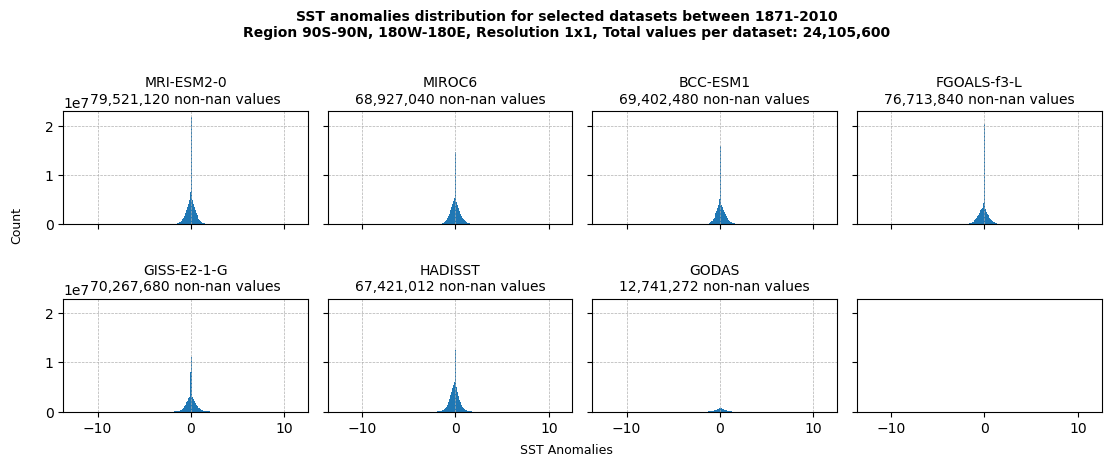

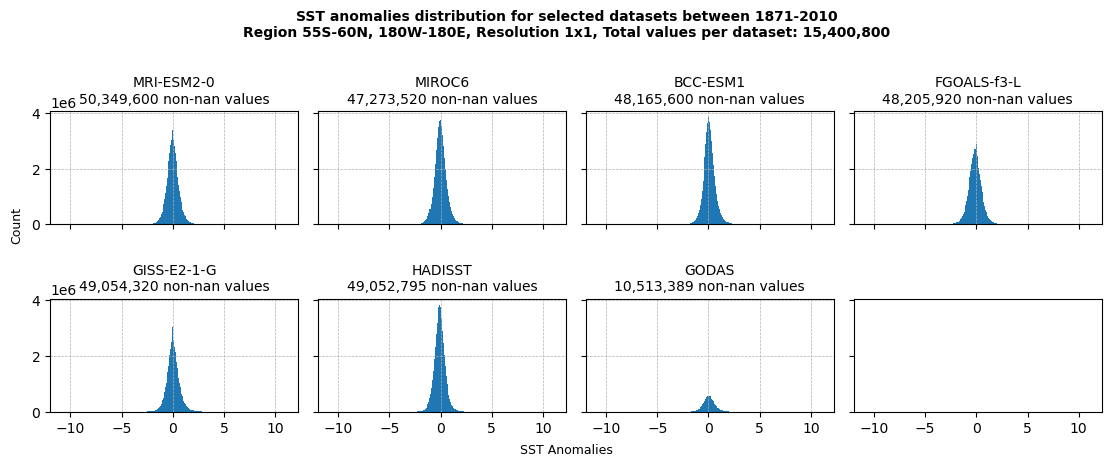

In [37]:
graph_utils.plot_distribution(tos_anom_1m_dict, 'tos_anom_1m', 200, train_start_year, test_end_year, -90, +90, 0, 360, resolution=1, subtitle=None, save_img=False, img_filename=None, img_folder=None)
graph_utils.plot_distribution(tos_anom_1m_dict, 'tos_anom_1m', 200, train_start_year, test_end_year, -55, 60, 0, 360, resolution=1, subtitle=None, save_img=False, img_filename=None, img_folder=None)

#### Compute monthly anomalies for a coarsened 5x5 degrees grid

In [38]:
tos_anom_1m_5x5_dict = dict()

for key, ds in tos_anom_1m_dict.items():
    # print(key)

    new_filename = key.replace("tos_anom_1m", "tos_anom_1m_5x5deg")
    # print(new_filename)
    if key.startswith("CMIP"):
        savepath = 'datasets/CMIP6/CMIP6_regridded/anom_1m_5x5deg/'
    elif key.startswith("OBS"):
        savepath = 'datasets/HadISST/HadISST_regridded/anom_1m_5x5deg/'
    elif key.startswith("ASSIM.NOAA"):
        savepath = 'datasets/GODAS/GODAS_regridded/anom_1m_5x5deg/'
    else:
        pritn("Unknown filename")
    
    os.makedirs(savepath, exist_ok=True) 
    nc_out = os.path.join(savepath, new_filename)

    # if anomalies file already exist on disk, load it
    if os.path.isfile(nc_out):
        print(f"{new_filename} already exist in {savepath}. Loading it...")
        tos_anom_1m_5x5_dict[new_filename] = xr.open_dataset(nc_out) # Store Dataset in dictionary 
        continue

    print(f"Coarsening grid for {key}")
    coarsened = ds.coarsen(dim={'lat': 5, 'lon': 5}, boundary='trim', side='left')
    tos_anom_1m_5x5_ds = coarsened.mean()
    # display(ds)
    # display(tos_anom_1m_5x5_ds)
    
    # Save Dataset to disk
    tos_anom_1m_5x5_ds.to_netcdf(nc_out)
    print('file written: {}\n'.format(nc_out))
    
    # Store Dataset in dictionary 
    tos_anom_1m_5x5_dict[new_filename] = tos_anom_1m_5x5_ds

CMIP.MRI.MRI-ESM2-0.historical.Omon.gn_cellarea.regridded_tos_anom_1m_5x5deg.nc already exist in datasets/CMIP6/CMIP6_regridded/anom_1m_5x5deg/. Loading it...
CMIP.MIROC.MIROC6.historical.Omon.gn_cellarea.regridded_tos_anom_1m_5x5deg.nc already exist in datasets/CMIP6/CMIP6_regridded/anom_1m_5x5deg/. Loading it...
CMIP.BCC.BCC-ESM1.historical.Omon.gn_cellarea.regridded_tos_anom_1m_5x5deg.nc already exist in datasets/CMIP6/CMIP6_regridded/anom_1m_5x5deg/. Loading it...
CMIP.CAS.FGOALS-f3-L.historical.Omon.gn_cellarea.regridded_tos_anom_1m_5x5deg.nc already exist in datasets/CMIP6/CMIP6_regridded/anom_1m_5x5deg/. Loading it...
CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.gn_cellarea.regridded_tos_anom_1m_5x5deg.nc already exist in datasets/CMIP6/CMIP6_regridded/anom_1m_5x5deg/. Loading it...
OBS.HAD.HADISST.regridded_tos_anom_1m_5x5deg.nc already exist in datasets/HadISST/HadISST_regridded/anom_1m_5x5deg/. Loading it...
Coarsening grid for ASSIM.NOAA.GODAS.pottmp.5m.C.regridded_tos_anom_1m

In [39]:
# example of one coarsened dataset:
tos_anom_1m_5x5_dict["CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.gn_cellarea.regridded_tos_anom_1m_5x5deg.nc"]

<xarray.Dataset> Size: 21MB
Dimensions:         (member_id: 1, dcpp_init_year: 1, time: 1980, lat: 36,
                     lon: 72)
Coordinates:
  * time            (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-1...
  * member_id       (member_id) <U8 32B 'r1i1p1f1'
  * dcpp_init_year  (dcpp_init_year) float64 8B nan
  * lat             (lat) float64 288B -87.5 -82.5 -77.5 ... 77.5 82.5 87.5
  * lon             (lon) float64 576B 2.5 7.5 12.5 17.5 ... 347.5 352.5 357.5
    areacello       (member_id, dcpp_init_year, lat, lon) float32 10kB ...
    month           (time) int64 16kB ...
Data variables:
    tos_anom_1m     (member_id, dcpp_init_year, time, lat, lon) float32 21MB ...

##### Plot anomalies distribution

In [40]:
# check that all datasets have same first and last date and lon/lat coordinates
for (name, ds), ax in zip(tos_anom_1m_5x5_dict.items(), axs.flat):
    data = ds['tos_anom_1m'].sel(time=slice(train_start_date, test_end_date))

    print(name)
    # check if all datasets have same first and last date
    first_date = pd.to_datetime(data.time[0].values)
    last_date = pd.to_datetime(data.time[-1].values)
    formatted_first_date = first_date.strftime('%Y-%m-%d')
    formatted_last_date = last_date.strftime('%Y-%m-%d')
    print(formatted_first_date, formatted_last_date)

    # check if all datasets have same first and last lon/lat coordinates
    print(data.lat[0].values, data.lat[-1].values, data.lon[0].values, data.lon[-1].values)
    print()

CMIP.MRI.MRI-ESM2-0.historical.Omon.gn_cellarea.regridded_tos_anom_1m_5x5deg.nc
1871-01-16 2010-12-16
-87.5 87.5 2.5 357.5

CMIP.MIROC.MIROC6.historical.Omon.gn_cellarea.regridded_tos_anom_1m_5x5deg.nc
1871-01-16 2010-12-16
-87.5 87.5 2.5 357.5

CMIP.BCC.BCC-ESM1.historical.Omon.gn_cellarea.regridded_tos_anom_1m_5x5deg.nc
1871-01-16 2010-12-16
-87.5 87.5 2.5 357.5

CMIP.CAS.FGOALS-f3-L.historical.Omon.gn_cellarea.regridded_tos_anom_1m_5x5deg.nc
1871-01-16 2010-12-16
-87.5 87.5 2.5 357.5

CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.gn_cellarea.regridded_tos_anom_1m_5x5deg.nc
1871-01-16 2010-12-16
-87.5 87.5 2.5 357.5

OBS.HAD.HADISST.regridded_tos_anom_1m_5x5deg.nc
1871-01-16 2010-12-16
-87.5 87.5 2.5 357.5

ASSIM.NOAA.GODAS.pottmp.5m.C.regridded_tos_anom_1m_5x5deg.nc
1980-01-01 2010-12-01
-87.5 87.5 2.5 357.5



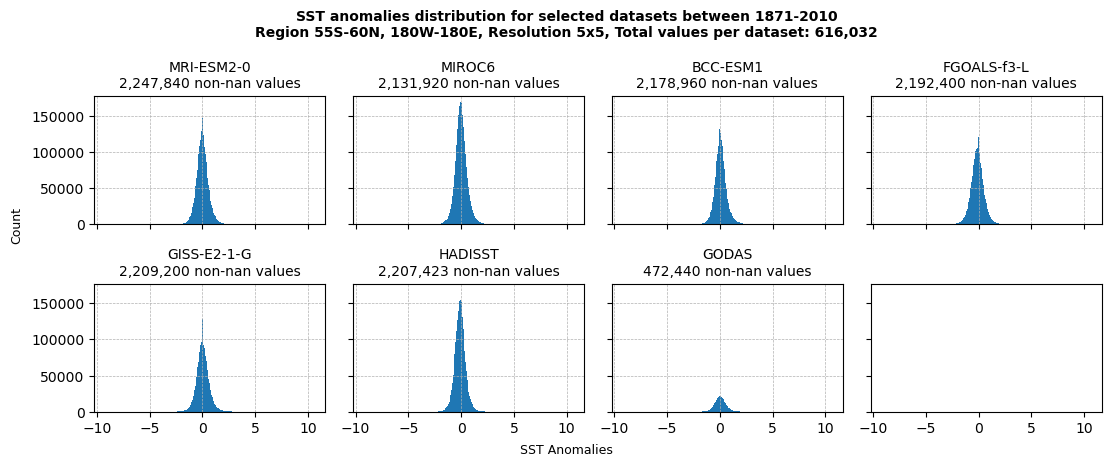

Saved distribution_sst_anoms_all_datasests.jpg to disk


In [41]:
# graph_utils.plot_distribution(tos_anom_1m_5x5_dict, 'tos_anom_1m', 200, train_start_year, test_end_year, -90, +90, 0, 360, resolution=5, subtitle=None, save_img=False, img_filename=None, img_folder=None)

img_filename = "distribution_sst_anoms_all_datasests.jpg"
graph_utils.plot_distribution(tos_anom_1m_5x5_dict, 'tos_anom_1m', 200, train_start_year, test_end_year, -55, 60, 0, 360, resolution=5, subtitle=None, save_img=True, img_filename=img_filename, img_folder=EDA_IMG_FOLDER)

#### Compute monthly anomalies for a coarsened 4x4 degrees grid

In [42]:
tos_anom_1m_4x4_dict = dict()

for key, ds in tos_anom_1m_dict.items():
    # print(key)

    new_filename = key.replace("tos_anom_1m", "tos_anom_1m_4x4deg")
    # print(new_filename)
    if key.startswith("CMIP"):
        savepath = 'datasets/CMIP6/CMIP6_regridded/anom_1m_4x4deg/'
    elif key.startswith("OBS"):
        savepath = 'datasets/HadISST/HadISST_regridded/anom_1m_4x4deg/'
    elif key.startswith("ASSIM.NOAA"):
        savepath = 'datasets/GODAS/GODAS_regridded/anom_1m_4x4deg/'
    else:
        pritn("Unknown filename")
    
    os.makedirs(savepath, exist_ok=True) 
    nc_out = os.path.join(savepath, new_filename)

    # if anomalies file already exist on disk, load it
    if os.path.isfile(nc_out):
        print(f"{new_filename} already exist in {savepath}. Loading it...")
        tos_anom_1m_4x4_dict[new_filename] = xr.open_dataset(nc_out) # Store Dataset in dictionary 
        continue

    print(f"Coarsening grid for {key}")
    coarsened = ds.coarsen(dim={'lat': 4, 'lon': 4}, boundary='trim', side='left')
    tos_anom_1m_4x4_ds = coarsened.mean()
    # display(ds)
    # display(tos_anom_1m_4x4_ds)
    
    # Save Dataset to disk
    tos_anom_1m_4x4_ds.to_netcdf(nc_out)
    print('file written: {}\n'.format(nc_out))
    
    # Store Dataset in dictionary 
    tos_anom_1m_4x4_dict[new_filename] = tos_anom_1m_4x4_ds

CMIP.MRI.MRI-ESM2-0.historical.Omon.gn_cellarea.regridded_tos_anom_1m_4x4deg.nc already exist in datasets/CMIP6/CMIP6_regridded/anom_1m_4x4deg/. Loading it...
CMIP.MIROC.MIROC6.historical.Omon.gn_cellarea.regridded_tos_anom_1m_4x4deg.nc already exist in datasets/CMIP6/CMIP6_regridded/anom_1m_4x4deg/. Loading it...
CMIP.BCC.BCC-ESM1.historical.Omon.gn_cellarea.regridded_tos_anom_1m_4x4deg.nc already exist in datasets/CMIP6/CMIP6_regridded/anom_1m_4x4deg/. Loading it...
CMIP.CAS.FGOALS-f3-L.historical.Omon.gn_cellarea.regridded_tos_anom_1m_4x4deg.nc already exist in datasets/CMIP6/CMIP6_regridded/anom_1m_4x4deg/. Loading it...
CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.gn_cellarea.regridded_tos_anom_1m_4x4deg.nc already exist in datasets/CMIP6/CMIP6_regridded/anom_1m_4x4deg/. Loading it...
OBS.HAD.HADISST.regridded_tos_anom_1m_4x4deg.nc already exist in datasets/HadISST/HadISST_regridded/anom_1m_4x4deg/. Loading it...
Coarsening grid for ASSIM.NOAA.GODAS.pottmp.5m.C.regridded_tos_anom_1m

### Plot monthly anomalies

In [43]:
# Generate a date range 
date_range = pd.date_range(start='1997-11', end='1998-01', freq='MS')
print(date_range)

# Format each date to "YYYY-MM" since not all the datasets use the same day of the month and time
time_arr = [date.strftime("%Y-%m") for date in date_range]
print(time_arr)

DatetimeIndex(['1997-11-01', '1997-12-01', '1998-01-01'], dtype='datetime64[ns]', freq='MS')
['1997-11', '1997-12', '1998-01']


#### 1x1 resolution

1997-11


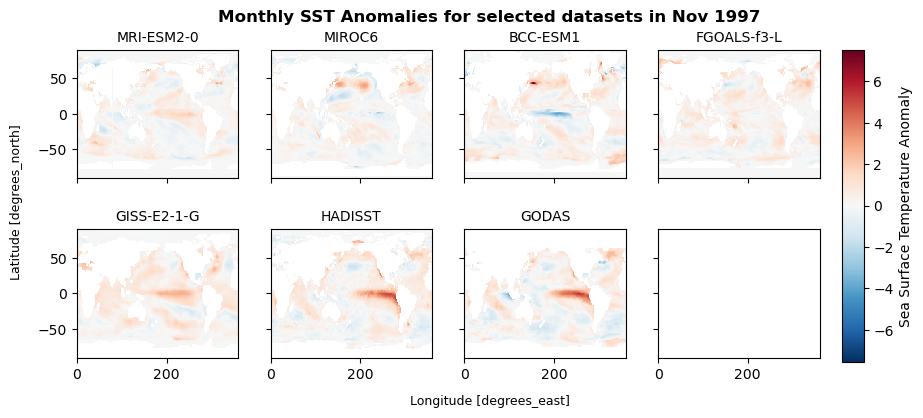

1997-12


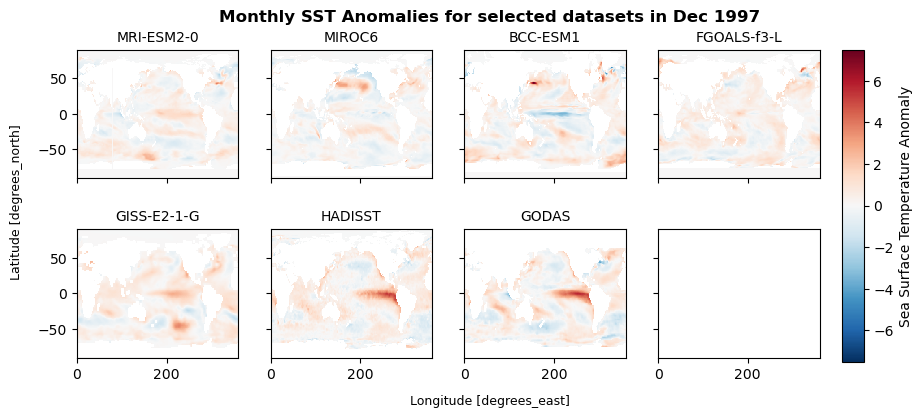

1998-01


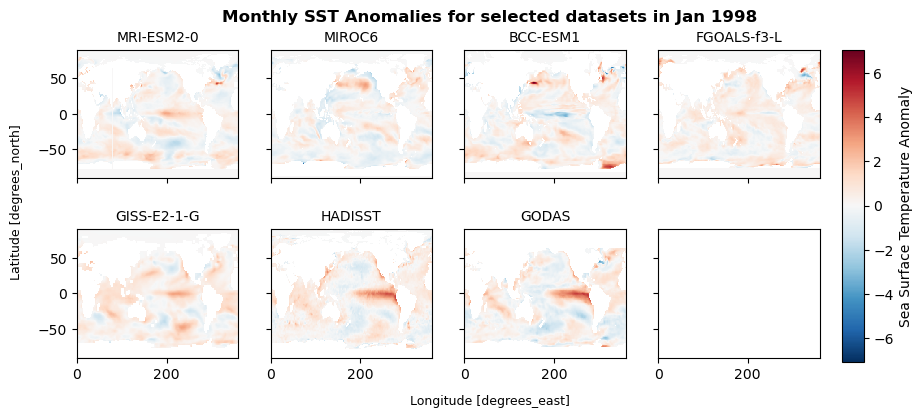

In [44]:
for time_sel in time_arr:
    print(time_sel)
    datetime_sel = datetime.strptime(time_sel, "%Y-%m") # string to date time
    formatted_time_sel = datetime_sel.strftime("%b %Y") # datetime to string
    
    
    # get min and max tos values across all datasets for shared color bar
    tos_min, tos_max = np.inf, -np.inf
    for key, ds in tos_anom_1m_dict.items():    
        # print(key)
        # display(ds.sel(time=slice("1997-01-16", None)))
        data = ds['tos_anom_1m'].sel(time=time_sel)

        tos_min = min(tos_min, data.min())
        tos_max = max(tos_max, data.max())
        
    # since we want the colorbar to be symetrical around zero, we need to take the maximum abs value and use it for min and max
    abs_tos_max = max(abs(tos_min), abs(tos_max))
    # abs_tos_max = 5
    
    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(11, 4), sharex=True, sharey=True)
    
    # Iterate over datasets and their respective axes
    for (name, ds), ax in zip(tos_anom_1m_dict.items(), axs.flat):
        data = ds['tos_anom_1m'].sel(time=time_sel)
        im = data.plot(ax=ax, add_colorbar=False, cmap='RdBu_r', vmin=-abs_tos_max, vmax=abs_tos_max)
        
        # Set title to the dataset's name
        ax.set_title(name.split(".")[2], fontsize=10)
    
        # Accessing axis labels
        xlabel = ax.get_xlabel()
        ylabel = ax.get_ylabel()
        ax.set(xlabel=None, ylabel=None)
    
        
    # Set title
    fig.suptitle(f"Monthly SST Anomalies for selected datasets in {formatted_time_sel}", fontweight="bold")
    
    # Create a shared colorbar for the entire figure
    fig.subplots_adjust(right=0.8, hspace=0.4) # Adjust spacing between subplots, as well as right margin for the colorbar
    cbar_ax = fig.add_axes([0.82, 0.10, 0.02, 0.78])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Sea Surface Temperature Anomaly')  
    
    fig.text(0.5, 0.0, xlabel, ha='center', va='center', fontsize=9)
    fig.text(0.07, 0.5, ylabel, ha='center', va='center', rotation='vertical', fontsize=9)
    
    plt.show()

#### 5x5 resolution

1997-11


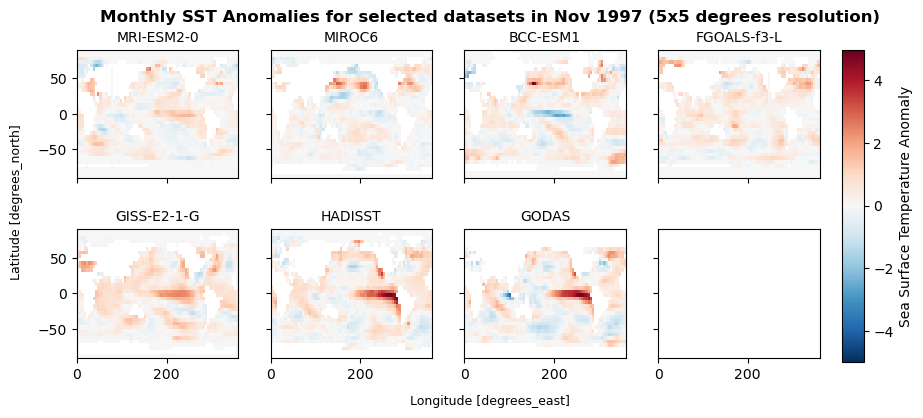

1997-12


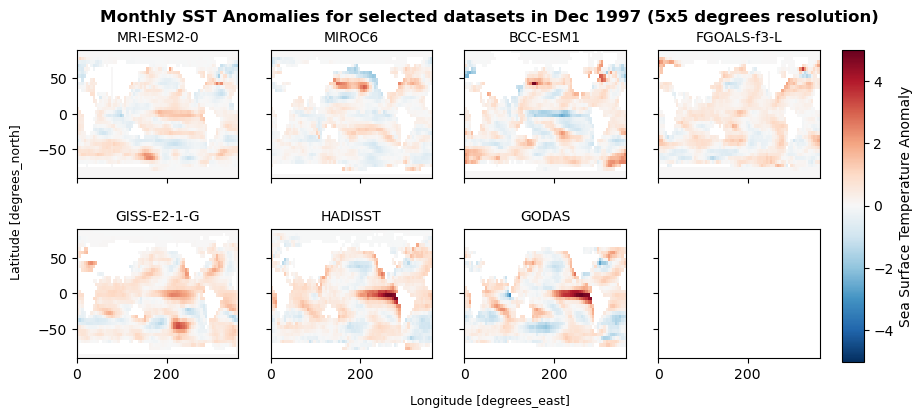

1998-01


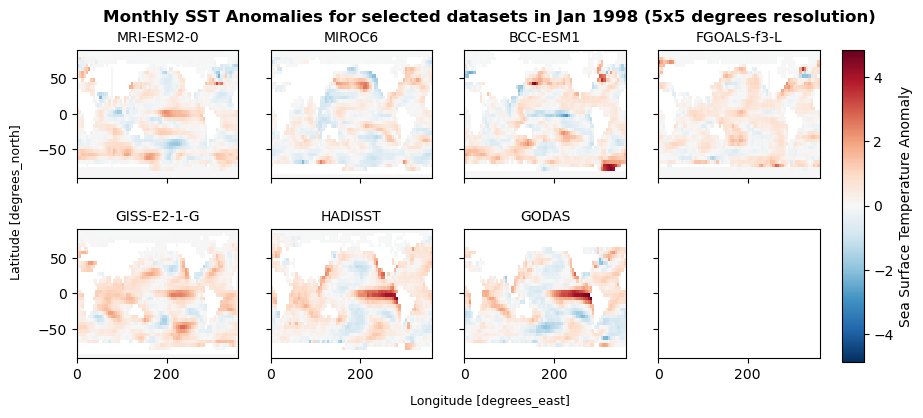

In [45]:
for time_sel in time_arr:
    print(time_sel)
    datetime_sel = datetime.strptime(time_sel, "%Y-%m") # string to date time
    formatted_time_sel = datetime_sel.strftime("%b %Y") # datetime to string
    
    
    # get min and max tos values across all datasets for shared color bar
    tos_min, tos_max = np.inf, -np.inf
    for key, ds in tos_anom_1m_5x5_dict.items():    
        # print(key)
        # display(ds.sel(time=slice("1997-01-16", None)))
        data = ds['tos_anom_1m'].sel(time=time_sel)

        tos_min = min(tos_min, data.min())
        tos_max = max(tos_max, data.max())
        
    # since we want the colorbar to be symetrical around zero, we need to take the maximum abs value and use it for min and max
    abs_tos_max = max(abs(tos_min), abs(tos_max))
    # abs_tos_max = 5
    
    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(11, 4), sharex=True, sharey=True)
    
    # Iterate over datasets and their respective axes
    for (name, ds), ax in zip(tos_anom_1m_5x5_dict.items(), axs.flat):
        data = ds['tos_anom_1m'].sel(time=time_sel)
        im = data.plot(ax=ax, add_colorbar=False, cmap='RdBu_r', vmin=-abs_tos_max, vmax=abs_tos_max)
        
        # Set title to the dataset's name
        ax.set_title(name.split(".")[2], fontsize=10)
    
        # Accessing axis labels
        xlabel = ax.get_xlabel()
        ylabel = ax.get_ylabel()
        ax.set(xlabel=None, ylabel=None)
    
        
    # Set title
    fig.suptitle(f"Monthly SST Anomalies for selected datasets in {formatted_time_sel} (5x5 degrees resolution)", fontweight="bold")
    
    # Create a shared colorbar for the entire figure
    fig.subplots_adjust(right=0.8, hspace=0.4) # Adjust spacing between subplots, as well as right margin for the colorbar
    cbar_ax = fig.add_axes([0.82, 0.10, 0.02, 0.78])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Sea Surface Temperature Anomaly')  
    
    fig.text(0.5, 0.0, xlabel, ha='center', va='center', fontsize=9)
    fig.text(0.07, 0.5, ylabel, ha='center', va='center', rotation='vertical', fontsize=9)
    
    plt.show()

## Compute and Plot 3-month rolling Temperature Anomalies

In [46]:
# compute 3-month running averages of SST anomalies
tos_anom_3m_dict = dict()

for key, ds in tos_anom_1m_dict.items():
    
    new_filename = key.replace("regridded_tos_anom_1m", "regridded_tos_anom_3m")
    if key.startswith("CMIP"):
        savepath = 'datasets/CMIP6/CMIP6_regridded/anom_3m/'
    elif key.startswith("OBS"):
        savepath = 'datasets/HadISST/HadISST_regridded/anom_3m/'
    elif key.startswith("ASSIM.NOAA"):
        savepath = 'datasets/GODAS/GODAS_regridded/anom_3m/'
    else:
        pritn("Unknown filename")
        
    os.makedirs(savepath, exist_ok=True) 
    nc_out = os.path.join(savepath, new_filename)

    # if anomalies file already exist on disk, load it
    if os.path.isfile(nc_out):
        print(f"{new_filename} already exist in {savepath}. Loading it from disk...")
        tos_anom_3m_dict[new_filename] = xr.open_dataset(nc_out) # Store Dataset in dictionary 
        continue


    print(f"Computing 3-month running averages of SST anomalies for {key}")
    
    # compute 3-month right-aligned moving average averages of SST anomalies 
    tos_anom_3m = ds['tos_anom_1m'].rolling(time=3, center=False).mean()

    # Assign the tos anomaly DataArray to a new Dataset
    tos_anom_3m_ds = tos_anom_3m.to_dataset(name='tos_anom_3m') 

    # Save Dataset to disk
    tos_anom_3m_ds.to_netcdf(nc_out)
    print('file written: {}\n'.format(nc_out))
    
    # Store Dataset in dictionary 
    tos_anom_3m_dict[new_filename] = tos_anom_3m_ds

CMIP.MRI.MRI-ESM2-0.historical.Omon.gn_cellarea.regridded_tos_anom_3m.nc already exist in datasets/CMIP6/CMIP6_regridded/anom_3m/. Loading it from disk...
CMIP.MIROC.MIROC6.historical.Omon.gn_cellarea.regridded_tos_anom_3m.nc already exist in datasets/CMIP6/CMIP6_regridded/anom_3m/. Loading it from disk...
CMIP.BCC.BCC-ESM1.historical.Omon.gn_cellarea.regridded_tos_anom_3m.nc already exist in datasets/CMIP6/CMIP6_regridded/anom_3m/. Loading it from disk...
CMIP.CAS.FGOALS-f3-L.historical.Omon.gn_cellarea.regridded_tos_anom_3m.nc already exist in datasets/CMIP6/CMIP6_regridded/anom_3m/. Loading it from disk...
CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.gn_cellarea.regridded_tos_anom_3m.nc already exist in datasets/CMIP6/CMIP6_regridded/anom_3m/. Loading it from disk...
OBS.HAD.HADISST.regridded_tos_anom_3m.nc already exist in datasets/HadISST/HadISST_regridded/anom_3m/. Loading it from disk...
Computing 3-month running averages of SST anomalies for ASSIM.NOAA.GODAS.pottmp.5m.C.regridded

### Plot 3-month anomalies

#### Faceting subplots per month

1997-11


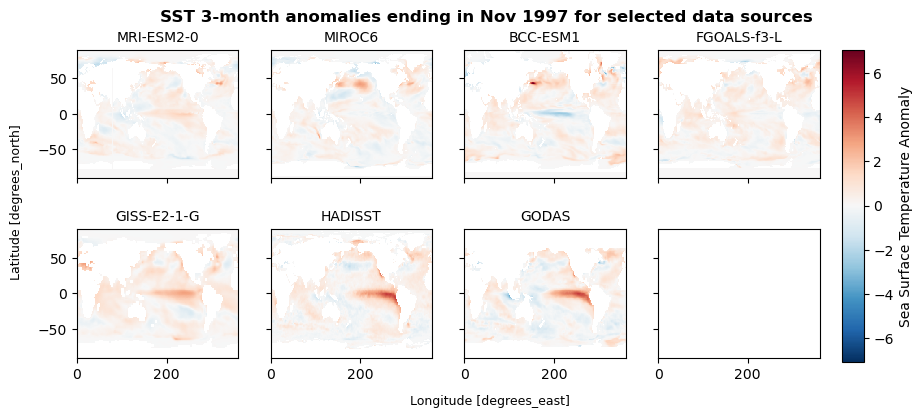

1997-12


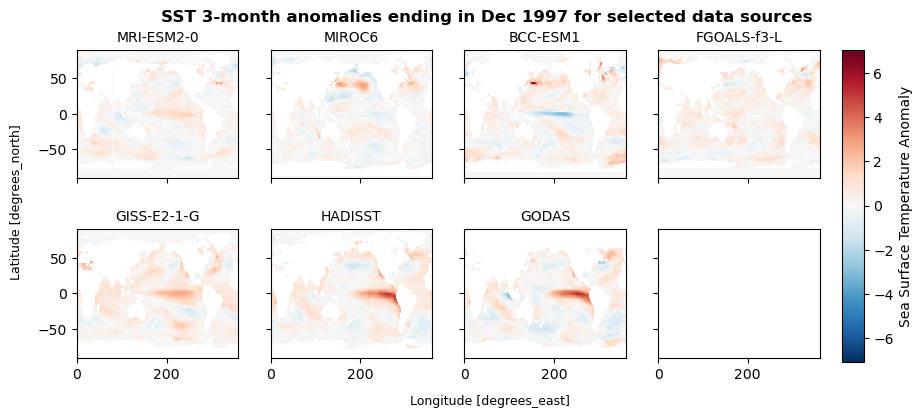

1998-01


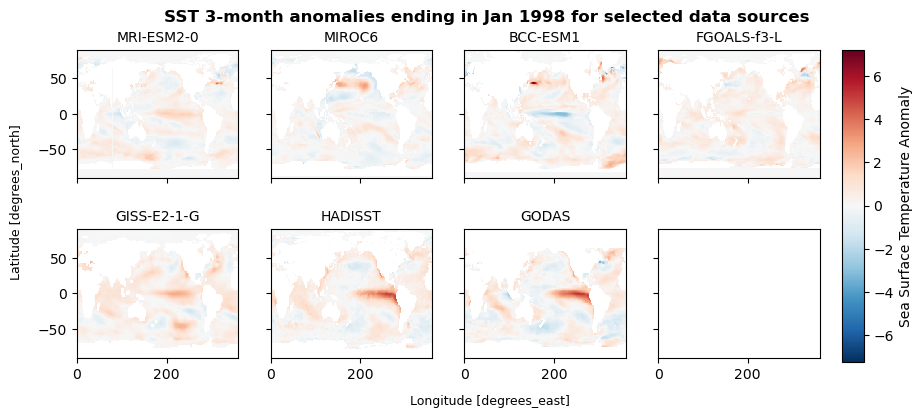

In [47]:
for time_sel in time_arr:
    print(time_sel)
    datetime_sel = datetime.strptime(time_sel.split('.')[0], "%Y-%m") # string to date time
    formatted_time_sel = datetime_sel.strftime("%b %Y") # datetime to string
    
    # get min and max tos values across all datasets for each month
    tos_min, tos_max = np.inf, -np.inf
    for key, ds in tos_anom_3m_dict.items():    
        data = ds['tos_anom_3m'].sel(time=time_sel,
                                     # lat=slice(min_lat, max_lat),
                                     # lon=slice(min_lon, max_lon)
                                    )
        tos_min = min(tos_min, data.min())
        tos_max = max(tos_max, data.max())

        
    # since we want the colorbar to be symetrical around zero, we need to take the maximum abs value and use it for min and max
    abs_tos_max = max(abs(tos_min), abs(tos_max))
    # print(abs_tos_max)
    # abs_tos_max = 5


    # plot
    fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(11, 4), sharex=True, sharey=True)
    
    # Iterate over datasets and their respective axes
    for (name, ds), ax in zip(tos_anom_3m_dict.items(), axs.flat):
        data = ds['tos_anom_3m'].sel(time=time_sel,
                                     # lat=slice(min_lat, max_lat),
                                     # lon=slice(min_lon, max_lon)
                                    )
        
        im = data.plot(ax=ax, add_colorbar=False, cmap='RdBu_r', vmin=-abs_tos_max, vmax=abs_tos_max)
        
        # Set title to the dataset's name
        ax.set_title(name.split(".")[2], fontsize=10)
    
        # Accessing axis labels
        xlabel = ax.get_xlabel()
        ylabel = ax.get_ylabel()
        ax.set(xlabel=None, ylabel=None)
    
        
    # Set title
    fig.suptitle(f"SST 3-month anomalies ending in {formatted_time_sel} for selected data sources ", fontweight="bold")
    
    # Create a shared colorbar for the entire figure
    fig.subplots_adjust(right=0.8, hspace=0.4) # Adjust spacing between subplots, as well as right margin for the colorbar
    cbar_ax = fig.add_axes([0.82, 0.10, 0.02, 0.78])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Sea Surface Temperature Anomaly')  
    
    fig.text(0.5, 0.0, xlabel, ha='center', va='center', fontsize=9)
    fig.text(0.07, 0.5, ylabel, ha='center', va='center', rotation='vertical', fontsize=9)
    
    plt.show()

#### Focus on NASA's GISS-E2-1-G model

In [48]:
list(tos_anom_3m_dict.keys())

['CMIP.MRI.MRI-ESM2-0.historical.Omon.gn_cellarea.regridded_tos_anom_3m.nc',
 'CMIP.MIROC.MIROC6.historical.Omon.gn_cellarea.regridded_tos_anom_3m.nc',
 'CMIP.BCC.BCC-ESM1.historical.Omon.gn_cellarea.regridded_tos_anom_3m.nc',
 'CMIP.CAS.FGOALS-f3-L.historical.Omon.gn_cellarea.regridded_tos_anom_3m.nc',
 'CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.gn_cellarea.regridded_tos_anom_3m.nc',
 'OBS.HAD.HADISST.regridded_tos_anom_3m.nc',
 'ASSIM.NOAA.GODAS.pottmp.5m.C.regridded_tos_anom_3m.nc']

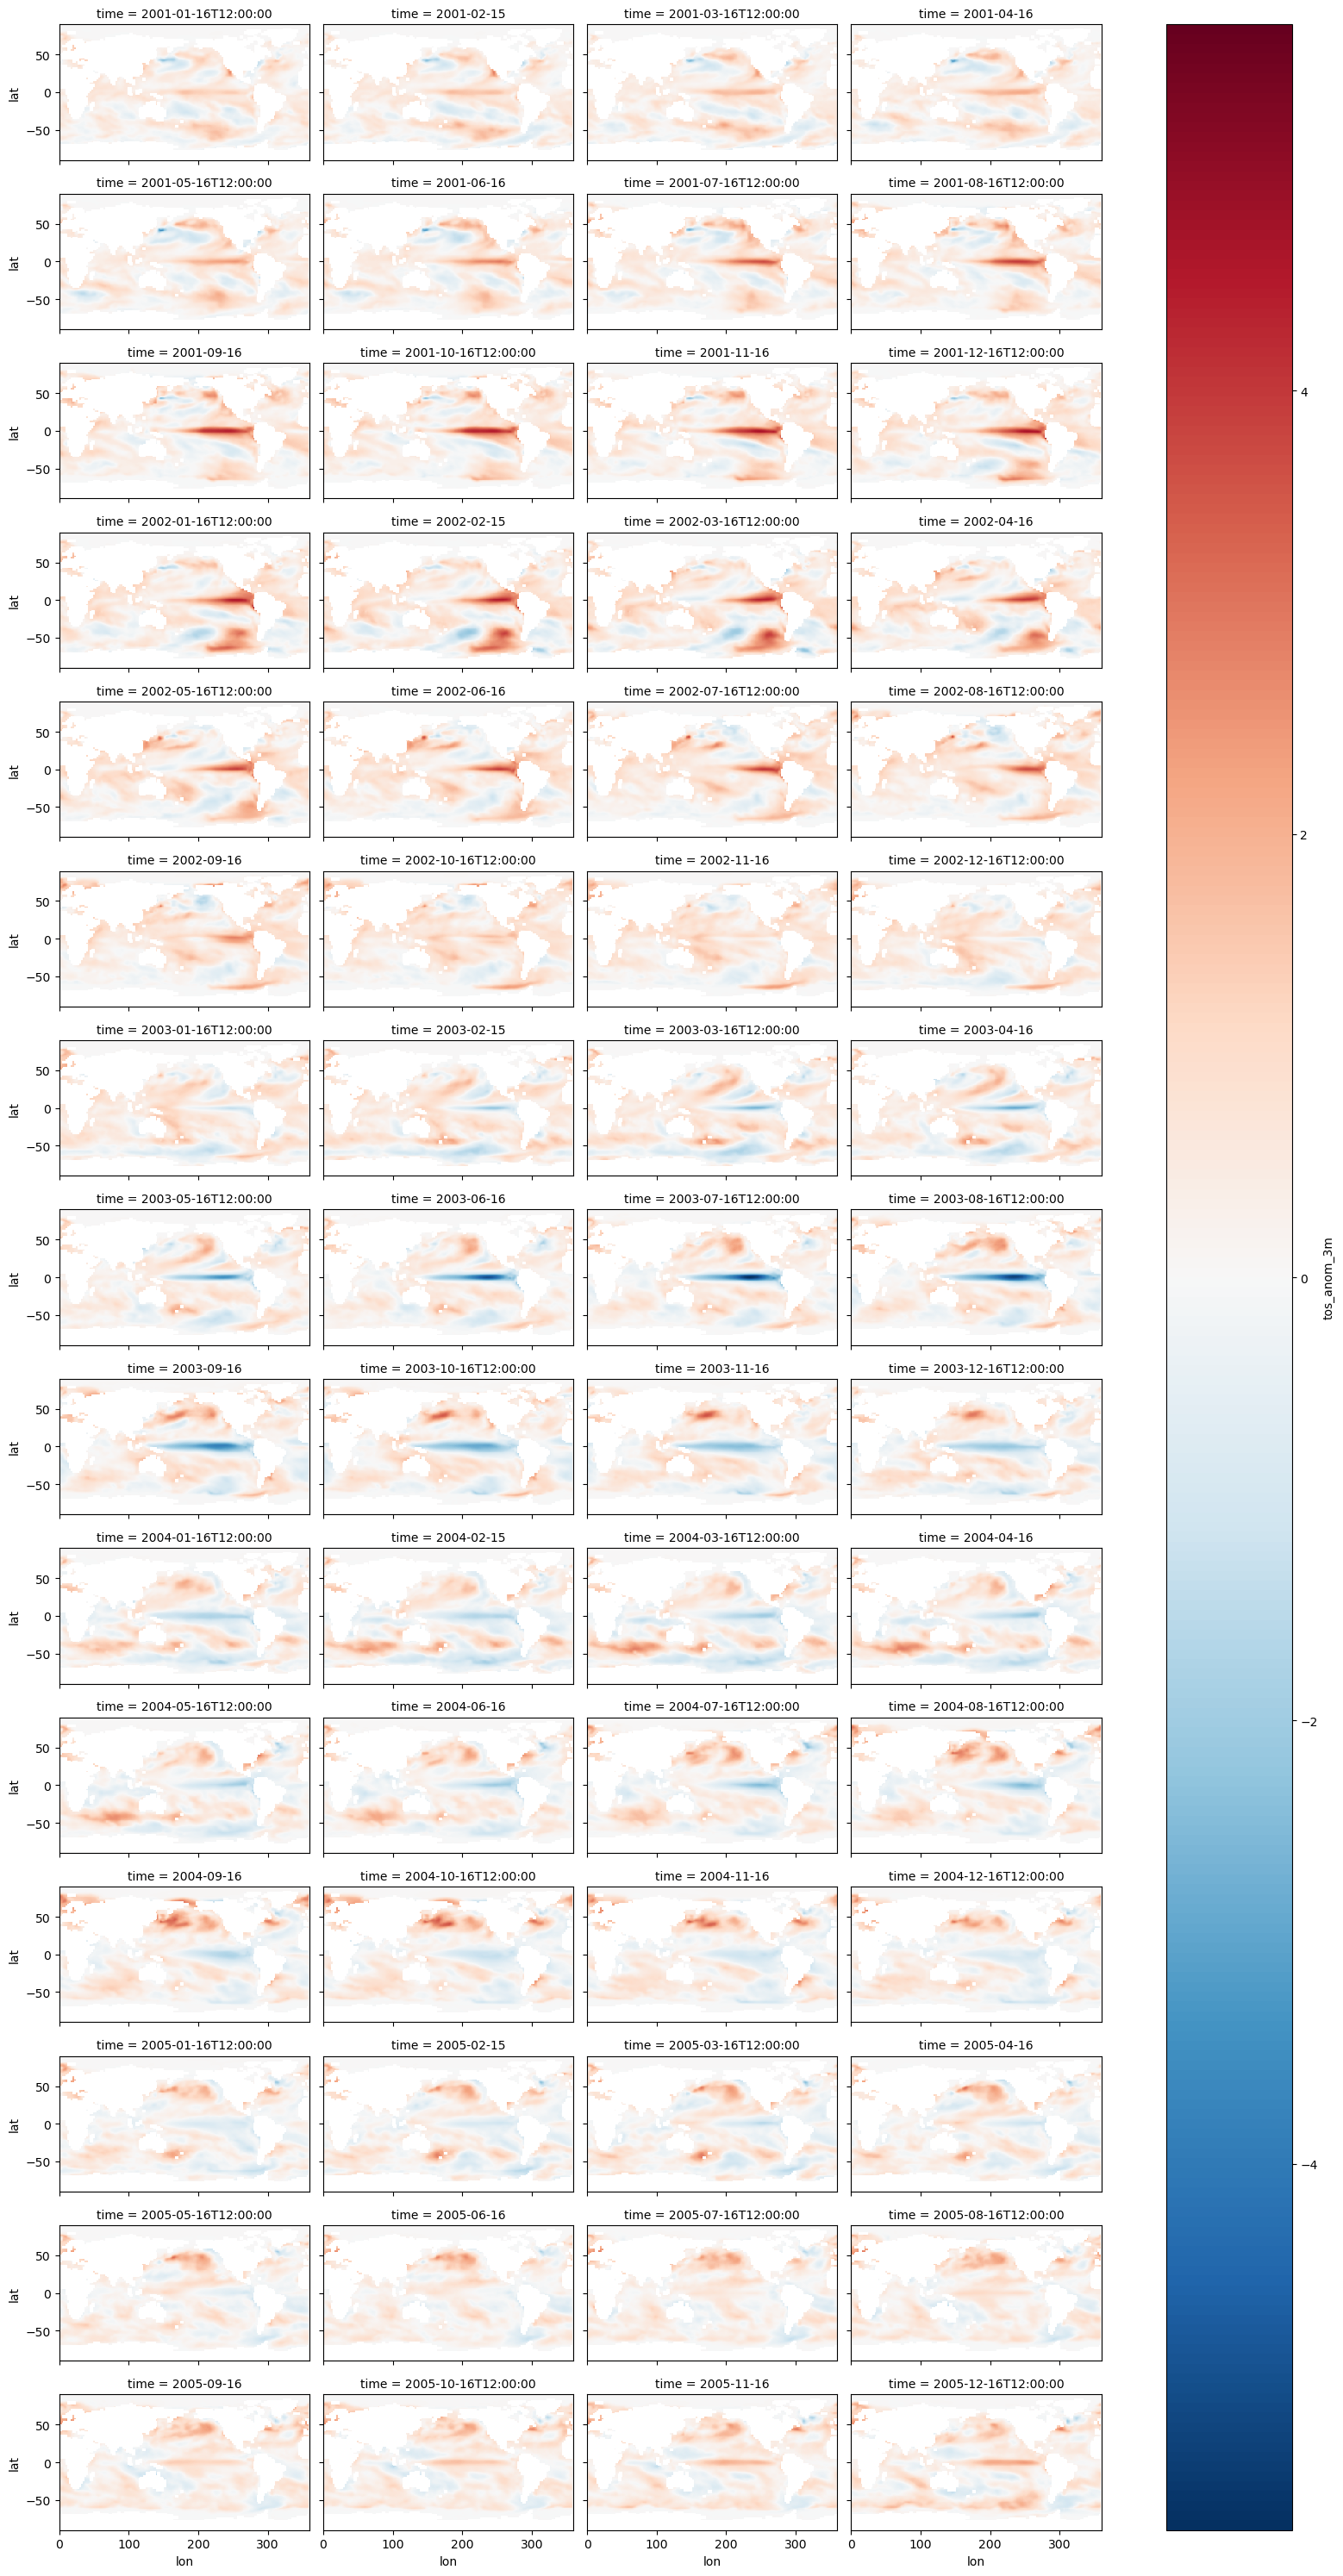

In [49]:
# Faceting
# ds = tos_anom_3m_dict["CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.regridded_tos_anom_3m.nc"]
ds = tos_anom_3m_dict["CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.gn_cellarea.regridded_tos_anom_3m.nc"]

figsize = (16, 30)
ds_slice = ds['tos_anom_3m'].sel(time=slice('2001', '2005'))
g = ds_slice.plot(x="lon", y="lat", col="time", col_wrap=4, figsize=figsize)


In [50]:
list(tos_anom_3m_dict)

['CMIP.MRI.MRI-ESM2-0.historical.Omon.gn_cellarea.regridded_tos_anom_3m.nc',
 'CMIP.MIROC.MIROC6.historical.Omon.gn_cellarea.regridded_tos_anom_3m.nc',
 'CMIP.BCC.BCC-ESM1.historical.Omon.gn_cellarea.regridded_tos_anom_3m.nc',
 'CMIP.CAS.FGOALS-f3-L.historical.Omon.gn_cellarea.regridded_tos_anom_3m.nc',
 'CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.gn_cellarea.regridded_tos_anom_3m.nc',
 'OBS.HAD.HADISST.regridded_tos_anom_3m.nc',
 'ASSIM.NOAA.GODAS.pottmp.5m.C.regridded_tos_anom_3m.nc']

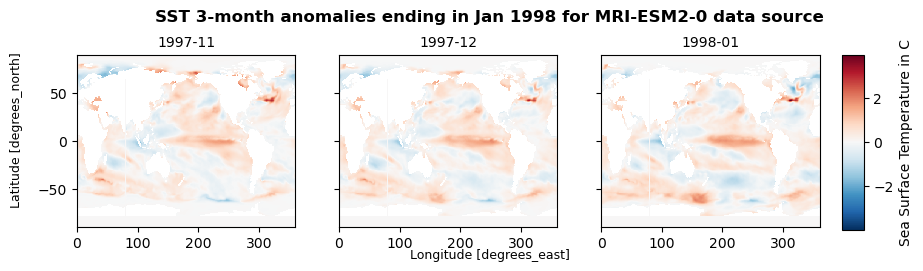

In [51]:
# ds = tos_anom_3m_dict["CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.regridded_tos_anom_3m.nc"]

# name = "CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.gn_cellarea.regridded_tos_anom_3m.nc"
# name = "CMIP.BCC.BCC-ESM1.historical.Omon.gn_cellarea.regridded_tos_anom_3m.nc"
name = "CMIP.MRI.MRI-ESM2-0.historical.Omon.gn_cellarea.regridded_tos_anom_3m.nc"
# name = "CMIP.CAS.FGOALS-f3-L.historical.Omon.gn_cellarea.regridded_tos_anom_3m.nc"


ds = tos_anom_3m_dict[name]


# get min and max tos values across all months
tos_min, tos_max = np.inf, -np.inf
for time in time_arr:    
    data = ds['tos_anom_3m'].sel(time=time_sel,
                                 # lat=slice(min_lat, max_lat),
                                 # lon=slice(min_lon, max_lon)
                                )
    tos_min = min(tos_min, data.min())
    tos_max = max(tos_max, data.max())

    
# since we want the colorbar to be symetrical around zero, we need to take the maximum abs value and use it for min and max
abs_tos_max = max(abs(tos_min), abs(tos_max))

fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(11, 2.5), sharex=True, sharey=True)


# interate over the cmip model datasets
# for (key, ds), ax in zip(tos_climatology_dict.items(), axs.flat):
for time, ax in zip(time_arr, axs.flat):    # dec, jan, feb
    data = ds['tos_anom_3m'].sel(time=time)
    # im = data.plot(ax=ax, add_colorbar=False, cmap='RdBu_r')

    im = data.plot(ax=ax, add_colorbar=False, cmap='RdBu_r', vmin=-abs_tos_max, vmax=abs_tos_max)
    
    # Set title to the dataset's name
    ax.set_title(time, fontsize=10)

    # Accessing axis labels
    xlabel = ax.get_xlabel()
    ylabel = ax.get_ylabel()
    ax.set(xlabel=None, ylabel=None)

    
# Set title
fig.suptitle(f"SST 3-month anomalies ending in {formatted_time_sel} for {name.split(".")[2]} data source", fontweight="bold")

# Create a shared colorbar for the entire figure
fig.subplots_adjust(right=0.8, hspace=0.4, top=0.8) # Adjust spacing between subplots, as well as right margin for the colorbar
cbar_ax = fig.add_axes([0.82, 0.10, 0.02, 0.7])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Sea Surface Temperature in C')  

fig.text(0.5, 0.0, xlabel, ha='center', va='center', fontsize=9)
fig.text(0.07, 0.5, ylabel, ha='center', va='center', rotation='vertical', fontsize=9)

plt.show()

### Compute Nino SST Indices
Nino SST Indices (Nino 1+2, 3, 3.4, 4; ONI and TNI): [link to NSF NCAR (National Center for Atmospheric Research) page](https://climatedataguide.ucar.edu/climate-data/nino-sst-indices-nino-12-3-34-4-oni-and-tni)

There are several indices used to monitor the tropical Pacific, all of which are based on sea surface temperature (SST) anomalies averaged across a given region.  Usually the anomalies are computed relative to a base period of 30 years.  The **Niño 3.4 index** and the **Oceanic Niño Index (ONI)** are the most commonly used indices to define El Niño and La Niña events.  Other indices are used to help characterize the unique nature of each event.

- **Niño 3.4 (5N-5S, 170W-120W)**:  The  Niño 3.4 anomalies may be thought of as representing the average equatorial SSTs across the Pacific from about the dateline to the South American coast.  The Niño 3.4 index typically uses a 5-month running mean, and El Niño or La  Niña events are defined when the  Niño 3.4 SSTs exceed +/- 0.4C for a period of six months or more.

- **ONI (5N-5S, 170W-120W)**: The ONI uses the same region as the Niño 3.4 index.  The ONI uses a 3-month running mean, and to be classified as a full-fledged El Niño or La Niña, the anomalies must exceed +0.5C or -0.5C for at least five consecutive months.  This is the operational definition used by NOAA.

#### Compute the Niño 3.4 index

In [52]:
nino34_dict = dict()

nino34_min_lat, nino34_max_lat = -5, 5
nino34_min_lon, nino34_max_lon = 190, 240
start_year, end_year = "1850", "2024"

for name, ds in tos_anom_1m_dict.items():

    new_filename = name.replace("nc", "nino34.txt")

    if new_filename.startswith("CMIP"):
        savepath = 'datasets/CMIP6/CMIP6_regridded/nino34/'
    elif new_filename.startswith("OBS"):
        savepath = 'datasets/HadISST/HadISST_regridded/nino34/'
    elif new_filename.startswith("ASSIM.NOAA"):
        savepath = 'datasets/GODAS/GODAS_regridded/nino34/'
    else:
        pritn("Unknown filename")
        
    os.makedirs(savepath, exist_ok=True) 
    filepath = os.path.join(savepath, new_filename)

    # # if anomalies file already exist on disk, load it
    if os.path.isfile(filepath):
        print(f"{new_filename} already exist in {savepath}. Loading it...")
        ts_nino34 = pd.read_csv(filepath, sep='\t', index_col=0) 
        nino34_dict[new_filename] = ts_nino34 # Store time series in dictionary 
        continue


     # Select the Niño 3.4 region 
    nino34_tos_anom = ds['tos_anom_1m'].sel(time=slice(start_year, end_year),
                             lat=slice(nino34_min_lat, nino34_max_lat),
                             lon=slice(nino34_min_lon, nino34_max_lon)
                            )

    # Compute the Niño 3.4 index (weighted average SST anomalies over the Niño 3.4 region)
    # https://foundations.projectpythia.org/core/xarray/enso-xarray.html#compute-the-anomalies
    if "areacello" in nino34_tos_anom.coords:
        nino34 = nino34_tos_anom.weighted(nino34_tos_anom.areacello).mean(dim=['lat', 'lon'])
    else: 
        print(f"No area cell values available for {name} dataset. Take the mean without weighted cells")
        nino34 = nino34_tos_anom.mean(dim=['lat', 'lon'])
    

    # Assign the tos anomaly DataArray to a new Dataset
    nino34_ds = nino34.to_dataset(name='nino34')

    # Convert to a pandas DataFrame
    df = nino34_ds.to_dataframe().reset_index()
    df['time'] = pd.to_datetime(df['time'])

    # convert to an oni time series
    ts_nino34 = df[['time', 'nino34']].set_index('time')

    # remove the hour component of the date index
    ts_nino34.index = ts_nino34.index.normalize()
    # print(ts_nino34)
    
    nino34_dict[new_filename] = ts_nino34
    ts_nino34.to_csv(filepath, header=True, index=True, sep='\t')

    print('file written: {}\n'.format(filepath))

CMIP.MRI.MRI-ESM2-0.historical.Omon.gn_cellarea.regridded_tos_anom_1m.nino34.txt already exist in datasets/CMIP6/CMIP6_regridded/nino34/. Loading it...
CMIP.MIROC.MIROC6.historical.Omon.gn_cellarea.regridded_tos_anom_1m.nino34.txt already exist in datasets/CMIP6/CMIP6_regridded/nino34/. Loading it...
CMIP.BCC.BCC-ESM1.historical.Omon.gn_cellarea.regridded_tos_anom_1m.nino34.txt already exist in datasets/CMIP6/CMIP6_regridded/nino34/. Loading it...
CMIP.CAS.FGOALS-f3-L.historical.Omon.gn_cellarea.regridded_tos_anom_1m.nino34.txt already exist in datasets/CMIP6/CMIP6_regridded/nino34/. Loading it...
CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.gn_cellarea.regridded_tos_anom_1m.nino34.txt already exist in datasets/CMIP6/CMIP6_regridded/nino34/. Loading it...
OBS.HAD.HADISST.regridded_tos_anom_1m.nino34.txt already exist in datasets/HadISST/HadISST_regridded/nino34/. Loading it...
No area cell values available for ASSIM.NOAA.GODAS.pottmp.5m.C.regridded_tos_anom_1m.nc dataset. Take the mean w

In [53]:
list(nino34_dict)

['CMIP.MRI.MRI-ESM2-0.historical.Omon.gn_cellarea.regridded_tos_anom_1m.nino34.txt',
 'CMIP.MIROC.MIROC6.historical.Omon.gn_cellarea.regridded_tos_anom_1m.nino34.txt',
 'CMIP.BCC.BCC-ESM1.historical.Omon.gn_cellarea.regridded_tos_anom_1m.nino34.txt',
 'CMIP.CAS.FGOALS-f3-L.historical.Omon.gn_cellarea.regridded_tos_anom_1m.nino34.txt',
 'CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.gn_cellarea.regridded_tos_anom_1m.nino34.txt',
 'OBS.HAD.HADISST.regridded_tos_anom_1m.nino34.txt',
 'ASSIM.NOAA.GODAS.pottmp.5m.C.regridded_tos_anom_1m.nino34.txt']

##### Plot all models' nino34 index from pandas timeseries

CMIP.MRI.MRI-ESM2-0.historical.Omon.gn_cellarea.regridded_tos_anom_1m.nino34.txt
CMIP.MIROC.MIROC6.historical.Omon.gn_cellarea.regridded_tos_anom_1m.nino34.txt
CMIP.BCC.BCC-ESM1.historical.Omon.gn_cellarea.regridded_tos_anom_1m.nino34.txt
CMIP.CAS.FGOALS-f3-L.historical.Omon.gn_cellarea.regridded_tos_anom_1m.nino34.txt
CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.gn_cellarea.regridded_tos_anom_1m.nino34.txt
OBS.HAD.HADISST.regridded_tos_anom_1m.nino34.txt
ASSIM.NOAA.GODAS.pottmp.5m.C.regridded_tos_anom_1m.nino34.txt


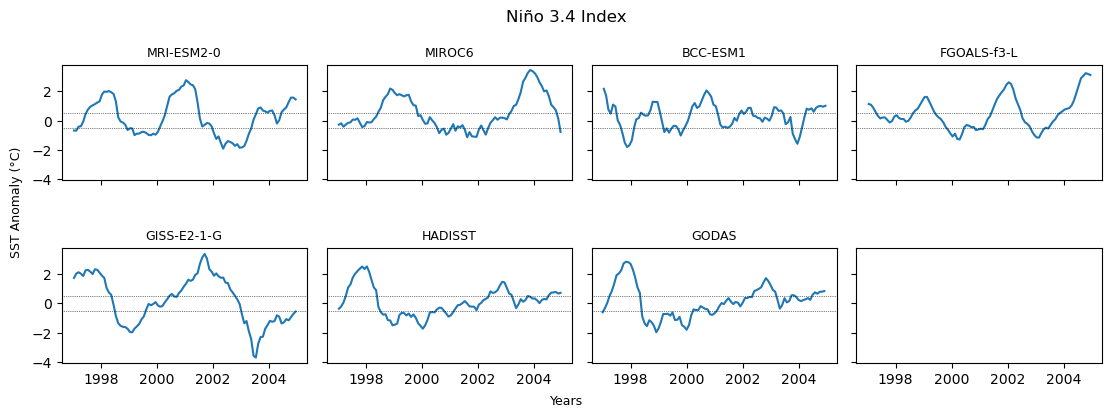

In [54]:
nino34_min_lat, nino34_max_lat = -5, 5
nino34_min_lon, nino34_max_lon = 190, 240
start_year, end_year = "1997", "2004"
# start_year, end_year = "1997", "1999"

# fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(11, 10), sharex=False, sharey=True)
fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(11, 4), sharex=True, sharey=True)

for (name, ts), ax in zip(nino34_dict.items(), axs.flat):
    print(name)

    ts.index = pd.to_datetime(ts.index)
    nino34_ts = ts[start_year:end_year]

    ax.plot(nino34_ts.index, nino34_ts.values)

    # Set x-axis major locator to yearly frequency
    ax.xaxis.set_major_locator(mdates.YearLocator(base=2))  # base=2 for every other year
    # ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    plt.suptitle('Niño 3.4 Index')
    ax.tick_params(axis='x', rotation=0)  # Ensure labels are horizontal

    ax.set_title(f'{name.split(".")[2]}', fontsize=9)
    ax.set(xlabel=None, ylabel=None)
    
    
    # legend
    ax.axhline(0.5, color='black', linewidth=0.5, linestyle='dotted')
    ax.axhline(-0.5, color='black', linewidth=0.5, linestyle='dotted')


fig.text(0.5, 0.0, 'Years', ha='center', va='center', fontsize=9)
fig.text(0.00, 0.5,  'SST Anomaly (°C)', ha='center', va='center', rotation='vertical', fontsize=9)
plt.tight_layout(pad=1.08, h_pad=3, w_pad=None, rect=None)

plt.show()


#### Compute the Oceanic Niño Index (ONI) time series

In [55]:
tos_anom_3m_dict

{'CMIP.MRI.MRI-ESM2-0.historical.Omon.gn_cellarea.regridded_tos_anom_3m.nc': <xarray.Dataset> Size: 514MB
 Dimensions:         (time: 1980, member_id: 1, dcpp_init_year: 1, lat: 180,
                      lon: 360)
 Coordinates:
   * time            (time) datetime64[ns] 16kB 1850-01-16T12:00:00 ... 2014-1...
   * member_id       (member_id) <U8 32B 'r1i1p1f1'
   * dcpp_init_year  (dcpp_init_year) float64 8B nan
   * lat             (lat) float64 1kB -89.5 -88.5 -87.5 -86.5 ... 87.5 88.5 89.5
   * lon             (lon) float64 3kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
     areacello       (member_id, dcpp_init_year, lat, lon) float32 259kB ...
     month           (time) int64 16kB ...
 Data variables:
     tos_anom_3m     (member_id, dcpp_init_year, time, lat, lon) float32 513MB ...,
 'CMIP.MIROC.MIROC6.historical.Omon.gn_cellarea.regridded_tos_anom_3m.nc': <xarray.Dataset> Size: 514MB
 Dimensions:         (time: 1980, member_id: 1, dcpp_init_year: 1, lat: 180,
                      l

In [56]:
oni_dict = dict()

nino34_min_lat, nino34_max_lat = -5, 5
nino34_min_lon, nino34_max_lon = 190, 240
start_year, end_year = "1850", "2024"

for name, ds in tos_anom_3m_dict.items():

    new_filename = name.replace("nc", "oni.txt")

    if new_filename.startswith("CMIP"):
        savepath = 'datasets/CMIP6/CMIP6_regridded/oni/'
    elif new_filename.startswith("OBS"):
        savepath = 'datasets/HadISST/HadISST_regridded/oni/'
    elif new_filename.startswith("ASSIM.NOAA"):
        savepath = 'datasets/GODAS/GODAS_regridded/oni/'
    else:
        pritn("Unknown filename")
        
    os.makedirs(savepath, exist_ok=True) 
    ts_out = os.path.join(savepath, new_filename)

    # # if anomalies file already exist on disk, load it
    if os.path.isfile(ts_out):
        print(f"{new_filename} already exist in {savepath}. Loading it...")
        ts_oni = pd.read_csv(ts_out, sep='\t', index_col=0) 
        oni_dict[new_filename] = ts_oni # Store time series in dictionary 
        continue


     # Select the Niño 3.4 region 
    nino34_tos_anom = ds['tos_anom_3m'].sel(time=slice(start_year, end_year),
                             lat=slice(nino34_min_lat, nino34_max_lat),
                             lon=slice(nino34_min_lon, nino34_max_lon)
                            )

    # Compute the ONI index (weighted 3-month average SST anomalies over the Niño 3.4 region)
    if "areacello" in nino34_tos_anom.coords:
        oni = nino34_tos_anom.weighted(nino34_tos_anom.areacello).mean(dim=['lat', 'lon'])
    else: 
        print(f"No area cell values available for {name} dataset. Take the mean without weighted cells")
        oni = nino34_tos_anom.mean(dim=['lat', 'lon'])
    

    # Assign the tos anomaly DataArray to a new Dataset
    oni_ds = oni.to_dataset(name='oni')

    # Convert to a pandas DataFrame
    df = oni_ds.to_dataframe().reset_index()
    df['time'] = pd.to_datetime(df['time'])

    # convert to an oni time series
    ts_oni = df[['time', 'oni']].set_index('time')

    # remove the hour component of the date index
    ts_oni.index = ts_oni.index.normalize()
    # print(ts_oni)
    
    oni_dict[new_filename] = ts_oni
    ts_oni.to_csv(ts_out, header=True, index=True, sep='\t')

    print('file written: {}\n'.format(ts_out))

CMIP.MRI.MRI-ESM2-0.historical.Omon.gn_cellarea.regridded_tos_anom_3m.oni.txt already exist in datasets/CMIP6/CMIP6_regridded/oni/. Loading it...
CMIP.MIROC.MIROC6.historical.Omon.gn_cellarea.regridded_tos_anom_3m.oni.txt already exist in datasets/CMIP6/CMIP6_regridded/oni/. Loading it...
CMIP.BCC.BCC-ESM1.historical.Omon.gn_cellarea.regridded_tos_anom_3m.oni.txt already exist in datasets/CMIP6/CMIP6_regridded/oni/. Loading it...
CMIP.CAS.FGOALS-f3-L.historical.Omon.gn_cellarea.regridded_tos_anom_3m.oni.txt already exist in datasets/CMIP6/CMIP6_regridded/oni/. Loading it...
CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.gn_cellarea.regridded_tos_anom_3m.oni.txt already exist in datasets/CMIP6/CMIP6_regridded/oni/. Loading it...
OBS.HAD.HADISST.regridded_tos_anom_3m.oni.txt already exist in datasets/HadISST/HadISST_regridded/oni/. Loading it...
No area cell values available for ASSIM.NOAA.GODAS.pottmp.5m.C.regridded_tos_anom_3m.nc dataset. Take the mean without weighted cells
file written: 

In [57]:
list(oni_dict)

['CMIP.MRI.MRI-ESM2-0.historical.Omon.gn_cellarea.regridded_tos_anom_3m.oni.txt',
 'CMIP.MIROC.MIROC6.historical.Omon.gn_cellarea.regridded_tos_anom_3m.oni.txt',
 'CMIP.BCC.BCC-ESM1.historical.Omon.gn_cellarea.regridded_tos_anom_3m.oni.txt',
 'CMIP.CAS.FGOALS-f3-L.historical.Omon.gn_cellarea.regridded_tos_anom_3m.oni.txt',
 'CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.gn_cellarea.regridded_tos_anom_3m.oni.txt',
 'OBS.HAD.HADISST.regridded_tos_anom_3m.oni.txt',
 'ASSIM.NOAA.GODAS.pottmp.5m.C.regridded_tos_anom_3m.oni.txt']

##### Plot all models oni from pandas timeseries

CMIP.MRI.MRI-ESM2-0.historical.Omon.gn_cellarea.regridded_tos_anom_3m.oni.txt
CMIP.MIROC.MIROC6.historical.Omon.gn_cellarea.regridded_tos_anom_3m.oni.txt
CMIP.BCC.BCC-ESM1.historical.Omon.gn_cellarea.regridded_tos_anom_3m.oni.txt
CMIP.CAS.FGOALS-f3-L.historical.Omon.gn_cellarea.regridded_tos_anom_3m.oni.txt
CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.gn_cellarea.regridded_tos_anom_3m.oni.txt
OBS.HAD.HADISST.regridded_tos_anom_3m.oni.txt
ASSIM.NOAA.GODAS.pottmp.5m.C.regridded_tos_anom_3m.oni.txt


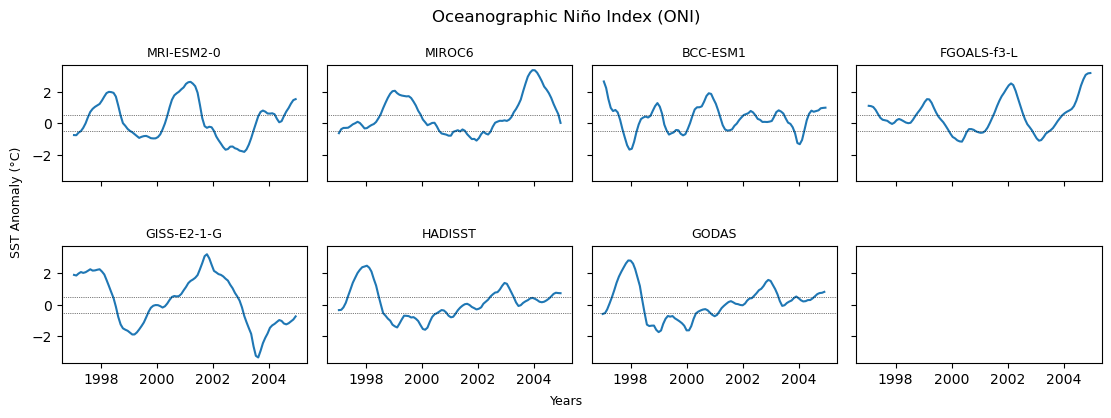

In [58]:
nino34_min_lat, nino34_max_lat = -5, 5
nino34_min_lon, nino34_max_lon = 190, 240
start_year, end_year = "1997", "2004"
# start_year, end_year = "1997", "1999"

fig, axs = plt.subplots(nrows=2, ncols=4, figsize=(11, 4), sharex=True, sharey=True)

for (name, ts), ax in zip(oni_dict.items(), axs.flat):
    print(name)

    ts.index = pd.to_datetime(ts.index)
    oni_ts = ts[start_year:end_year]
    
    ax.plot(oni_ts.index, oni_ts.values)

    # Set x-axis major locator to yearly frequency
    ax.xaxis.set_major_locator(mdates.YearLocator(base=2))  # base=2 for every other year
    # ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    
    ax.tick_params(axis='x', rotation=0)  # Ensure labels are horizontal

    ax.set_title(f'{name.split(".")[2]}', fontsize=9)
    ax.set(xlabel=None, ylabel=None)
    
    # legend
    ax.axhline(0.5, color='black', linewidth=0.5, linestyle='dotted')
    ax.axhline(-0.5, color='black', linewidth=0.5, linestyle='dotted')


fig.text(0.5, 0.0, 'Years', ha='center', va='center', fontsize=9)
fig.text(0.00, 0.5,  'SST Anomaly (°C)', ha='center', va='center', rotation='vertical', fontsize=9)
plt.suptitle('Oceanographic Niño Index (ONI)')
plt.tight_layout(pad=1.08, h_pad=3, w_pad=None, rect=None)

plt.show()


### Compare Nino 3.4 Index with ONI

#### Load indices from observation dataset

In [59]:
# Load Nino 3.4 index from observations dataset
# new_filename = "OBS.HAD.HADISST.regridded_tos_anom_1m.nino34.txt"
# savepath = 'datasets/HadISST/HadISST_regridded/nino34/'
# filepath = os.path.join(savepath, new_filename)
# ts_nino34_hadisst =  pd.read_csv(filepath, sep='\t', index_col=0) 

# # Load ONI index from observations dataset
# new_filename = "OBS.HAD.HADISST.regridded_tos_anom_1m.nino34.txt"
# savepath = 'datasets/HadISST/HadISST_regridded/nino34/'
# filepath = os.path.join(savepath, new_filename)
# ts_nino34_hadisst =  pd.read_csv(filepath, sep='\t', index_col=0) 

ts_hadisst_nino34 = nino34_dict["OBS.HAD.HADISST.regridded_tos_anom_1m.nino34.txt"]
ts_hadisst_oni = oni_dict["OBS.HAD.HADISST.regridded_tos_anom_3m.oni.txt"]

#### Plot Nino 3.4 vs ONI index

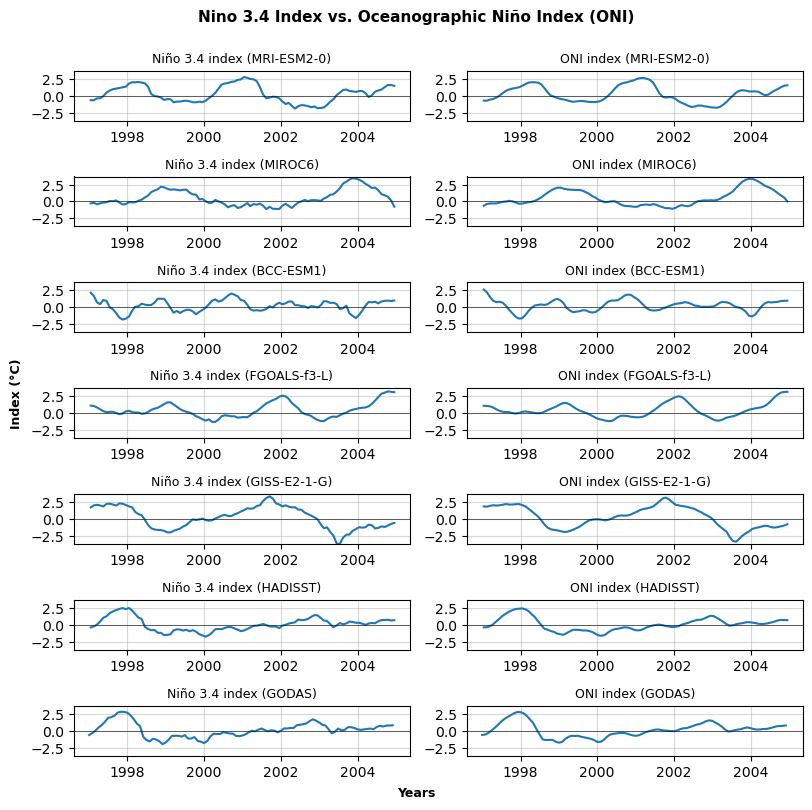

In [60]:
nino34_min_lat, nino34_max_lat = -5, 5
nino34_min_lon, nino34_max_lon = 190, 240
start_year, end_year = "1997", "2004"

# observations (HadISST) timeseries to compare with
# ts_hadisst_slice_nino34 = ts_hadisst_nino34[start_year:end_year]
# ts_hadisst_slice_oni = ts_hadisst_oni[start_year:end_year]

# Determine the global maximum among all datasets to ensure that the y-axis limits are set symmetrically for all subplots
global_max = 0
for (name_nino34, ts_nino34), (name_oni, ts_oni) in zip(nino34_dict.items(), oni_dict.items()):
    ts_nino34.index = pd.to_datetime(ts_nino34.index)
    ts_oni.index = pd.to_datetime(ts_oni.index)
    
    nino34_ts = ts_nino34[start_year:end_year]       
    oni_ts = ts_oni[start_year:end_year]
    
    current_max = max(np.max(np.abs(nino34_ts.values)), np.max(np.abs(oni_ts.values)))
    if current_max > global_max:
        global_max = current_max



fig, axs = plt.subplots(nrows=len(nino34_dict), ncols=2, figsize=(8, 8), sharex=True, sharey=True)

for ((name_nino34, ts_nino34), (name_oni, ts_oni)), (ax1, ax2) in zip(zip(nino34_dict.items(), oni_dict.items()), axs):

    # print(name_nino34)
    # print(name_oni)

    if name_nino34.split(".")[2] != name_oni.split(".")[2]:
        print("The sources of the datasets dont match")

    ts_nino34.index = pd.to_datetime(ts_nino34.index)
    ts_oni.index = pd.to_datetime(ts_oni.index)

    nino34_ts = ts_nino34[start_year:end_year]       
    oni_ts = ts_oni[start_year:end_year]


    # Nino34 index plots
    ax1.plot(nino34_ts.index, nino34_ts.values)
    # ax1.plot(ts_hadisst_slice_oni.index, ts_hadisst_slice_oni.values, label="observations (HadISST)", linestyle="dashed", linewidth=1, alpha=0.4) 
    ax1.set_ylim(-global_max, global_max)
    ax1.xaxis.set_major_locator(mdates.YearLocator(base=2))
    ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax1.tick_params(axis='x', which='both', bottom=True, labelbottom=True) 
    ax1.tick_params(axis='y', which='both', left=True, labelleft=True) 
    ax1.set_title(f'Niño 3.4 index ({name_nino34.split(".")[2]})', fontsize=9)
    # ax1.axhline(0.4, color='black', linewidth=0.5, linestyle='dotted')
    # ax1.axhline(-0.4, color='black', linewidth=0.5, linestyle='dotted')
    ax1.axhline(0, color='black', linewidth=0.4)
    ax1.grid(True, alpha=0.5)
    # ax1.set_ylabel('Index [°C]', fontsize=9)

    # ONI index plots
    ax2.plot(oni_ts.index, oni_ts.values)
    # ax2.plot(ts_hadisst_slice_nino34.index, ts_hadisst_slice_nino34.values, label="observations (HadISST)", linestyle="dashed", linewidth=1, alpha=0.4) 
    ax2.set_ylim(-global_max, global_max)
    ax2.xaxis.set_major_locator(mdates.YearLocator(base=2))
    ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    ax2.tick_params(axis='x', which='both', bottom=True, labelbottom=True) 
    ax2.tick_params(axis='y', which='both', left=True, labelleft=True) 
    ax2.set_title(f'ONI index ({name_oni.split(".")[2]})', fontsize=9)
    # ax2.axhline(0.5, color='black', linewidth=0.5, linestyle='dotted')
    # ax2.axhline(-0.5, color='black', linewidth=0.5, linestyle='dotted')
    ax2.axhline(0, color='black', linewidth=0.4)
    ax2.grid(True, alpha=0.5)
        
plt.suptitle('Nino 3.4 Index vs. Oceanographic Niño Index (ONI)', fontweight='bold', fontsize=11)
fig.text(0.5, 0.0, 'Years', ha='center', va='center', fontsize=9, fontweight='bold')
fig.text(0.00, 0.5,  'Index (°C)', ha='center', va='center', rotation='vertical', fontsize=9, fontweight='bold')
plt.tight_layout(pad=1.0, h_pad=1, w_pad=None, rect=[0,0,1,0.98]) # rect=(left, bottom, right, top), default: (0, 0, 1, 1)

plt.show()

##### Plot all models oni from xarray

CMIP.MRI.MRI-ESM2-0.historical.Omon.gn_cellarea.regridded_tos_anom_3m.nc
CMIP.MIROC.MIROC6.historical.Omon.gn_cellarea.regridded_tos_anom_3m.nc
CMIP.BCC.BCC-ESM1.historical.Omon.gn_cellarea.regridded_tos_anom_3m.nc
CMIP.CAS.FGOALS-f3-L.historical.Omon.gn_cellarea.regridded_tos_anom_3m.nc
CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.gn_cellarea.regridded_tos_anom_3m.nc
OBS.HAD.HADISST.regridded_tos_anom_3m.nc
No area cell values available for OBS.HAD.HADISST.regridded_tos_anom_3m.nc dataset. Take the mean without weighted cells


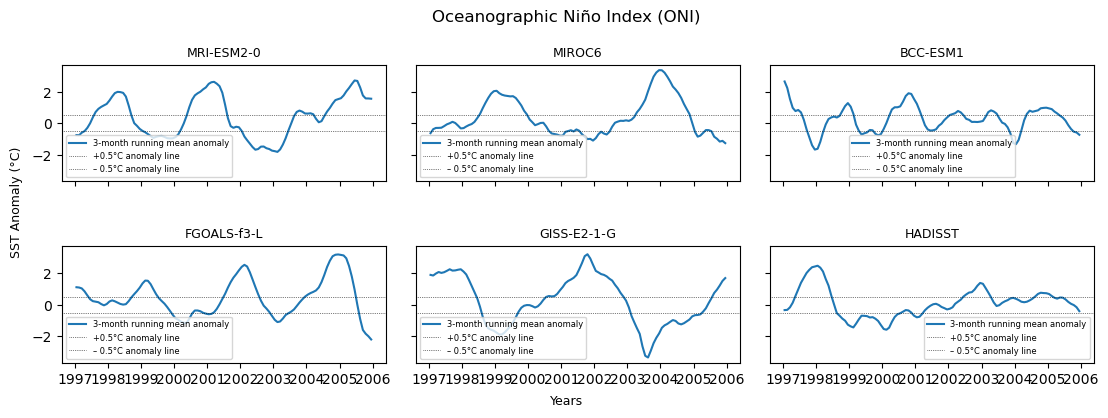

In [61]:
nino34_min_lat, nino34_max_lat = -5, 5
nino34_min_lon, nino34_max_lon = 190, 240
start_year, end_year = "1997", "2005"

# fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(11, 10), sharex=False, sharey=True)
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(11, 4), sharex=True, sharey=True)

for (name, ds), ax in zip(tos_anom_3m_dict.items(), axs.flat):
    print(name)

     # Select the Niño 3.4 region 
    nino34_tos_anom = ds['tos_anom_3m'].sel(time=slice(start_year, end_year),
                             lat=slice(nino34_min_lat, nino34_max_lat),
                             lon=slice(nino34_min_lon, nino34_max_lon)
                            )

    # Compute the Niño 3.4 index (weighted average SST anomalies over the Niño 3.4 region)
    # https://foundations.projectpythia.org/core/xarray/enso-xarray.html#compute-the-anomalies
    if "areacello" in nino34_tos_anom.coords:
        oni = nino34_tos_anom.weighted(nino34_tos_anom.areacello).mean(dim=['lat', 'lon'])
    else: 
        print(f"No area cell values available for {name} dataset. Take the mean without weighted cells")
        oni = nino34_tos_anom.mean(dim=['lat', 'lon'])
    oni_val = oni.values.squeeze()

    # Plot
    oni.plot(ax=ax, label='weighted')
    plt.suptitle('Oceanographic Niño Index (ONI)')
    ax.set_title(f'{name.split(".")[2]}', fontsize=9)
    ax.set(xlabel=None, ylabel=None)

    # legend
    ax.axhline(0.5, color='black', linewidth=0.5, linestyle='dotted')
    ax.axhline(-0.5, color='black', linewidth=0.5, linestyle='dotted')
    
    # ax.fill_between(oni.time.values, 0.5, oni_val, where=oni_val>=0.5, interpolate=True, color='red')
    # ax.fill_between(oni.time.values, -0.5, oni_val, where=oni_val<=-0.5, interpolate=True, color='blue')
    ax.legend(['3-month running mean anomaly', '+0.5°C anomaly line', '– 0.5°C anomaly line'], fontsize=6)


fig.text(0.5, 0.0, 'Years', ha='center', va='center', fontsize=9)
fig.text(0.00, 0.5,  'SST Anomaly (°C)', ha='center', va='center', rotation='vertical', fontsize=9)
plt.tight_layout(pad=1.08, h_pad=3, w_pad=None, rect=None)

plt.show()


### Lag Plots

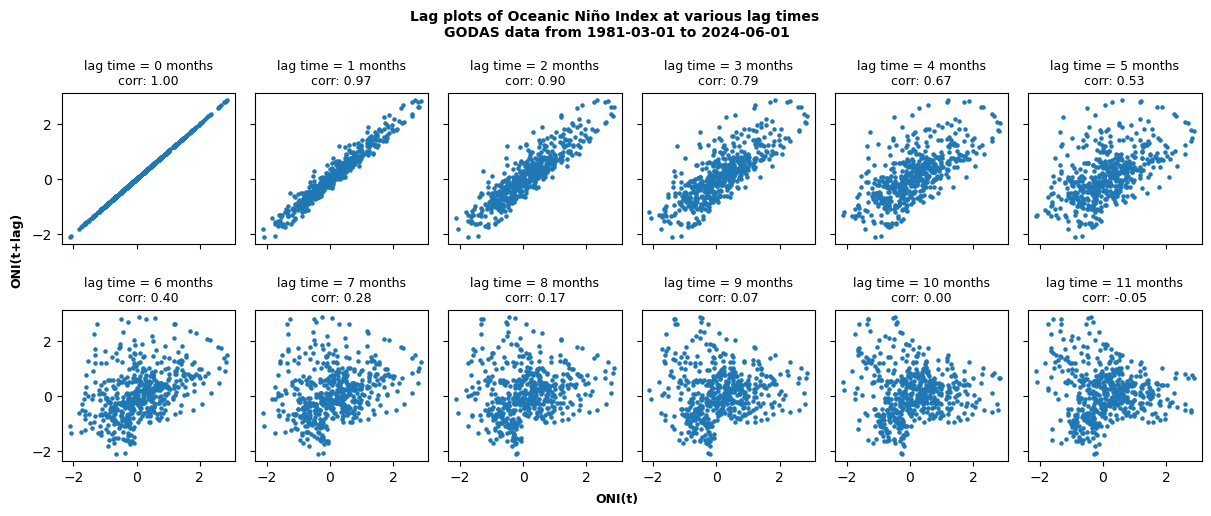

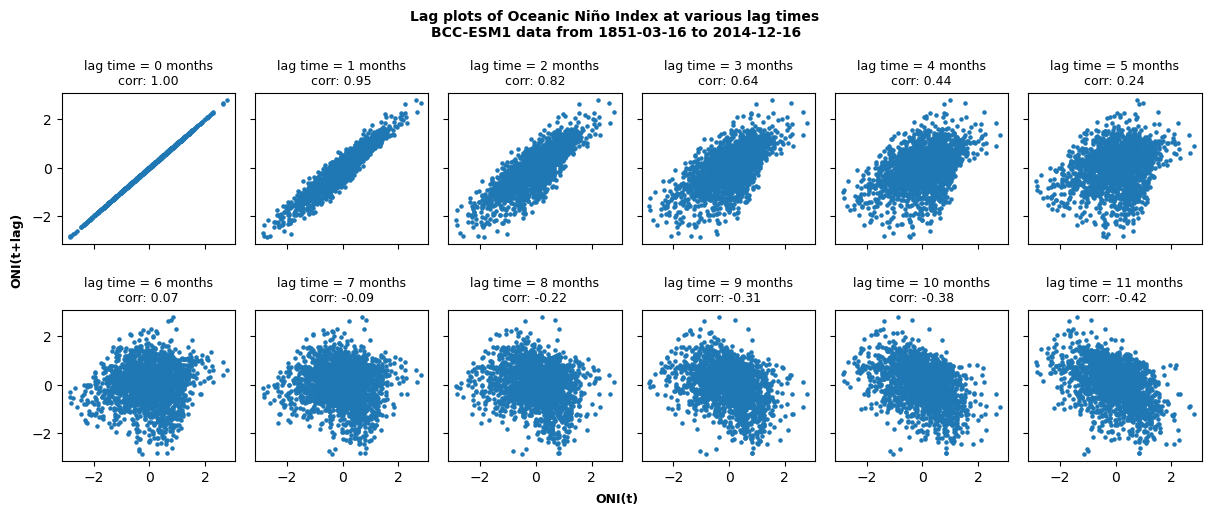

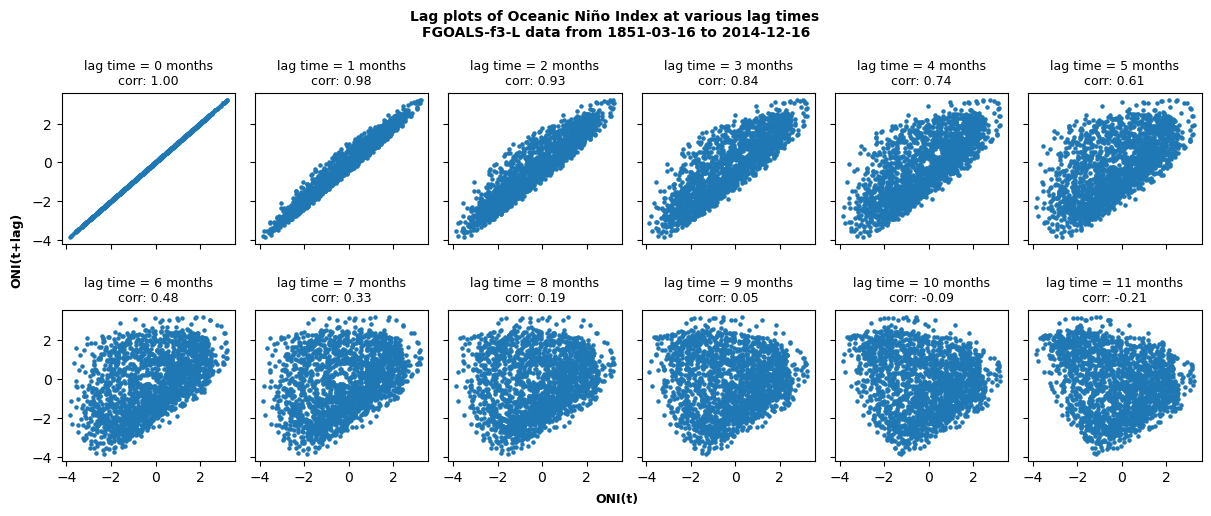

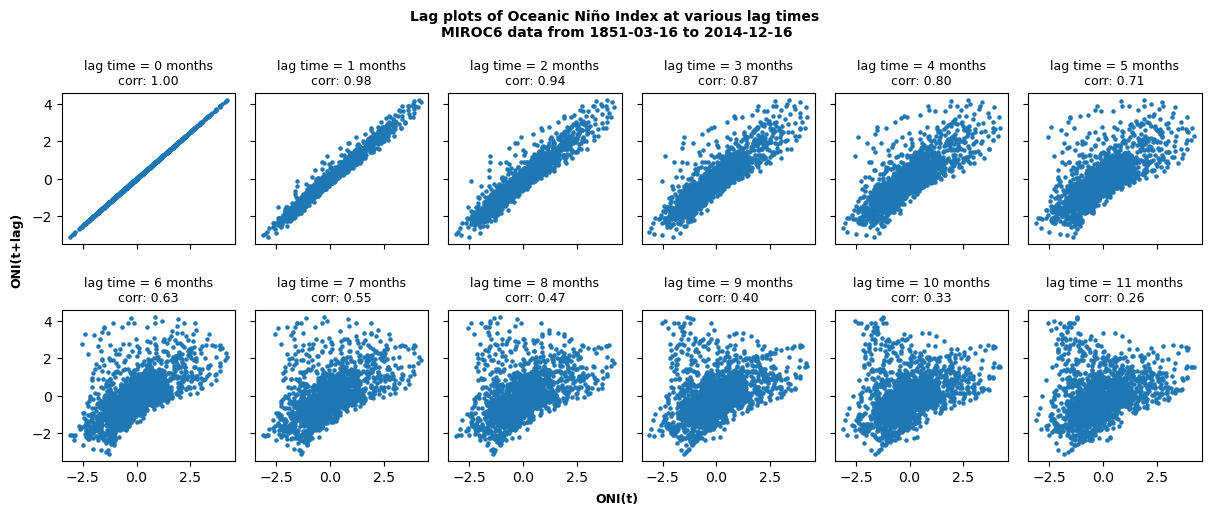

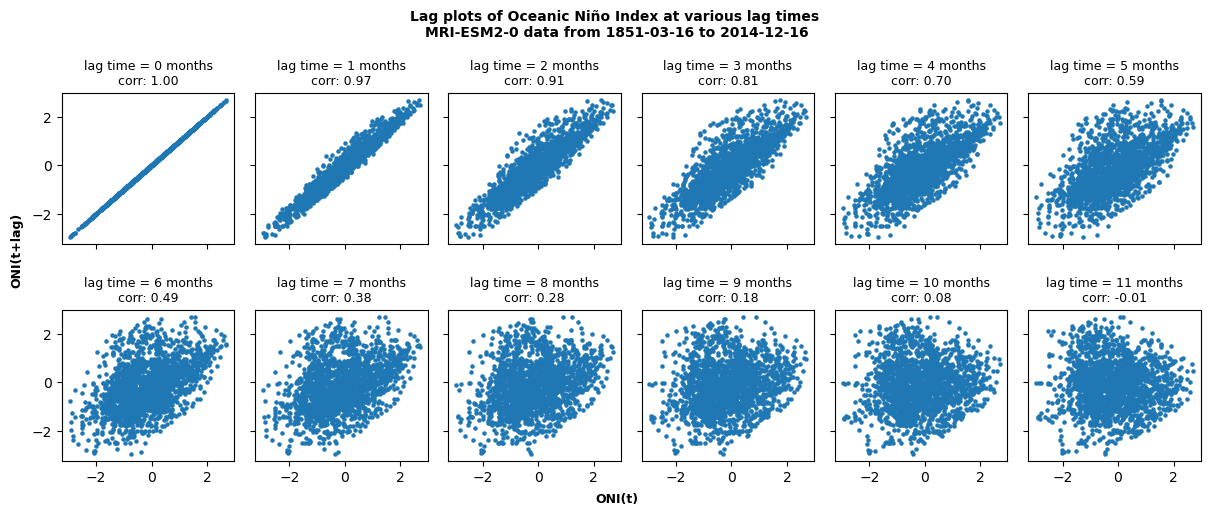

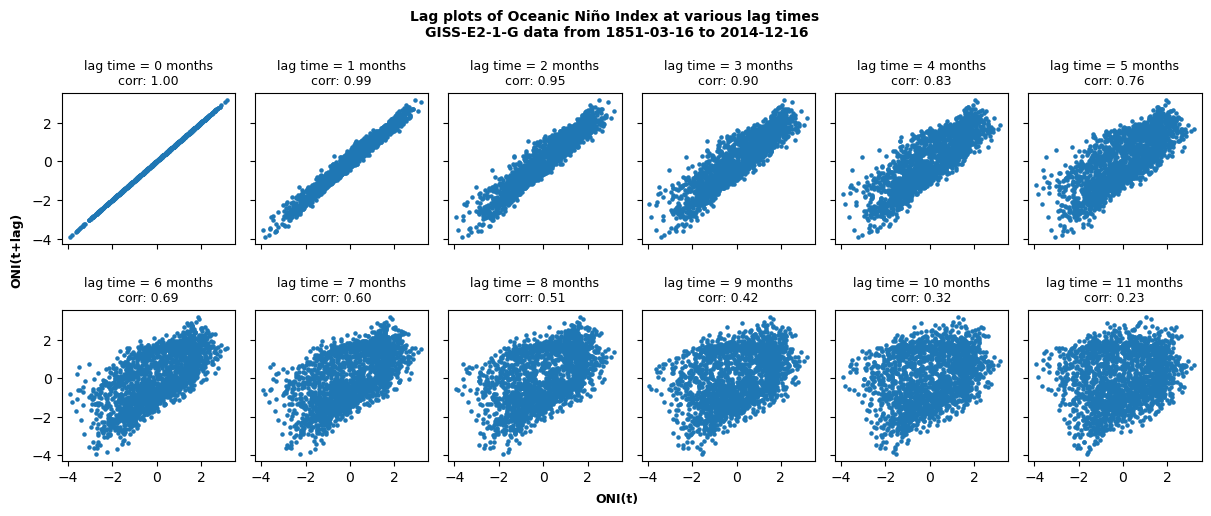

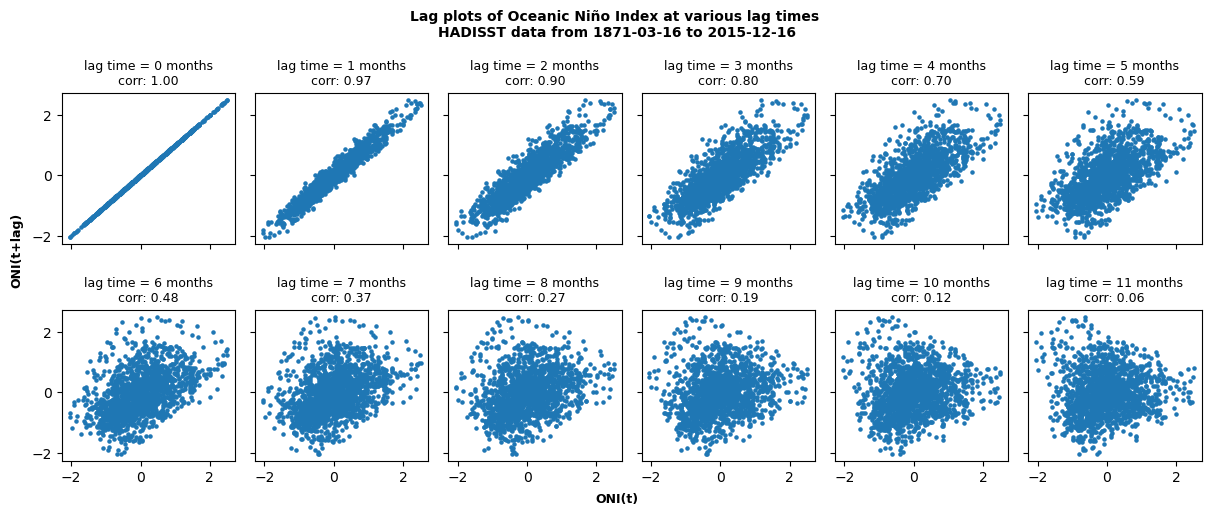

In [62]:
for oni_key, oni_df in sorted(list(oni_dict.items())):
    source_id = oni_key.split(".")[2]

    # create a dataframe with values shifted by increasing lag value for each column
    for lag in range(1,13):
        name = f"oni+{lag}"
        oni_df[name] = oni_df['oni'].shift(lag)

    # remove first rows containing nan because of the shift
    oni_df = oni_df.dropna()

    # lag plots and corresponding correlation coefficients
    fig, axs = plt.subplots(nrows=2, ncols=6, figsize=(12, 5), sharex=True, sharey=True)
    for i, (col, ax) in enumerate(zip(oni_df.columns, axs.flat)):
        corr, _ = scipy.stats.pearsonr(oni_df["oni"], oni_df[col])
        ax.scatter(oni_df["oni"], oni_df[col], s=5)
        ax.set_title(f"lag time = {i} months\ncorr: {corr:.2f}", fontsize=9)

    suptitle = f'Lag plots of Oceanic Niño Index at various lag times \n{source_id} data from {oni_df.index[0].date()} to {oni_df.index[-1].date()}'
    fig.suptitle(suptitle, fontsize=10, fontweight="bold")
    
    fig.text(0.5, 0.0, 'ONI(t)', ha='center', va='center', fontsize=9, fontweight="bold")
    fig.text(0.00, 0.5,  'ONI(t+lag)', ha='center', va='center', rotation='vertical', fontsize=9, fontweight="bold")
    plt.tight_layout( h_pad=2, w_pad=None, rect=None)
    
    plt.show()
    plt.close()

### 1 model

In [63]:
name

'oni+12'

In [64]:
list(tos_anom_3m_dict.keys())

['CMIP.MRI.MRI-ESM2-0.historical.Omon.gn_cellarea.regridded_tos_anom_3m.nc',
 'CMIP.MIROC.MIROC6.historical.Omon.gn_cellarea.regridded_tos_anom_3m.nc',
 'CMIP.BCC.BCC-ESM1.historical.Omon.gn_cellarea.regridded_tos_anom_3m.nc',
 'CMIP.CAS.FGOALS-f3-L.historical.Omon.gn_cellarea.regridded_tos_anom_3m.nc',
 'CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.gn_cellarea.regridded_tos_anom_3m.nc',
 'OBS.HAD.HADISST.regridded_tos_anom_3m.nc',
 'ASSIM.NOAA.GODAS.pottmp.5m.C.regridded_tos_anom_3m.nc']

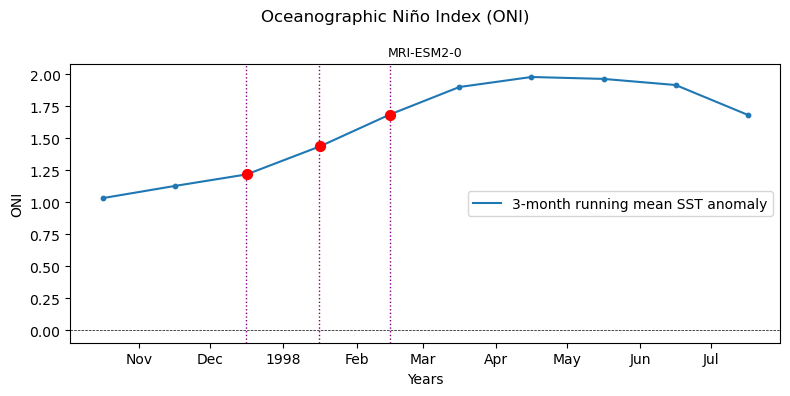

In [65]:
nino34_min_lat, nino34_max_lat = -5, 5
nino34_min_lon, nino34_max_lon = 190, 240
start_year, end_year = "1997-10-01", "1998-08-01"

# name = "CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.gn_cellarea.regridded_tos_anom_3m.nc"
# name = "CMIP.BCC.BCC-ESM1.historical.Omon.gn_cellarea.regridded_tos_anom_3m.nc"
name = "CMIP.MRI.MRI-ESM2-0.historical.Omon.gn_cellarea.regridded_tos_anom_3m.nc"

ds = tos_anom_3m_dict[name]

# fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(11, 10), sharex=False, sharey=True)
fig, ax = plt.subplots(figsize=(8, 4))  # This setup helps in adjusting size easily


# Select the Niño 3.4 region 
nino34_tos_anom = ds['tos_anom_3m'].sel(time=slice(start_year, end_year),
                         lat=slice(nino34_min_lat, nino34_max_lat),
                         lon=slice(nino34_min_lon, nino34_max_lon)
                        )

# Compute the Niño 3.4 index (weighted average SST anomalies over the Niño 3.4 region)
# https://foundations.projectpythia.org/core/xarray/enso-xarray.html#compute-the-anomalies
oni = nino34_tos_anom.weighted(nino34_tos_anom.areacello).mean(dim=['lat', 'lon'])
oni_val = oni.values.squeeze()


# Plot
oni.plot(ax=ax)

# plot points for every data point
ax.scatter(oni.time, oni, s=10)  # s is the size of the points

dates_to_highlight = pd.to_datetime(["1997-12-16", "1998-1-16", "1998-02-15"])
highlight_points = oni.sel(time=slice(dates_to_highlight[0], dates_to_highlight[-1]))

# Add scatter point for each date in the dates to highligth
ax.scatter(highlight_points.time, highlight_points, color='red', s=50, zorder=5, label='Highlighted Dates')

# Add vertical lines for each date in the dates to highligth
for date in dates_to_highlight:
    ax.axvline(x=date, color='purple', linestyle='dotted', linewidth=1, label=f'Key Date: {date}')



plt.suptitle('Oceanographic Niño Index (ONI)')

ax.set_title(f'{name.split(".")[2]}', fontsize=9)
ax.set(xlabel=None, ylabel=None)
ax.set_ylabel('ONI')
ax.set_xlabel('Years')
# ax.axhline(0.5, color='black', linewidth=0.5, linestyle='dotted')
ax.axhline(0, color='black', linewidth=0.5, linestyle='dashed')
# ax.axhline(-0.5, color='black', linewidth=0.5, linestyle='dotted')

# ax.fill_between(oni.time.values, 0.5, oni_val, where=oni_val>=0.5, interpolate=True, color='red')
# ax.fill_between(oni.time.values, -0.5, oni_val, where=oni_val<=-0.5, interpolate=True, color='blue')
    
# plt.legend(['3-month running mean anomaly', '+0.5°C anomaly line', '– 0.5°C anomaly line'])
plt.legend(['3-month running mean SST anomaly'])
plt.tight_layout(pad=1.08, h_pad=3, w_pad=None, rect=None)
plt.show()

In [66]:
# nino34_min_lat, nino34_max_lat = -5, 5
# nino34_min_lon, nino34_max_lon = 190, 240

# nino34_tos_anom = ds['tos_anom_3m'].sel(time=slice("1990", "2024"),
#                              lat=slice(nino34_min_lat, nino34_max_lat),
#                              lon=slice(nino34_min_lon, nino34_max_lon)
#                             )
# nino34_tos_anom
# oni = nino34_tos_anom.weighted(tos_nino34.areacello).mean(dim=['lat', 'lon']) # should the average be weigthed??
# oni_val = oni.values.squeeze()
# # https://foundations.projectpythia.org/core/xarray/enso-xarray.html#compute-the-anomalies

# fig, ax = plt.subplots()

# oni.plot(ax=ax)
# plt.suptitle('SST anomalies over the Niño 3.4 region')
# plt.title('Data from NASA Goddard Institute for Space Studies climate model GISS-E2-1-G', fontsize=8)
# plt.ylabel('SST Anomaly (°C)')
# plt.xlabel('Years')
# plt.axhline(0.5, color='black', linewidth=0.5, linestyle='dotted')
# plt.axhline(-0.5, color='black', linewidth=0.5, linestyle='dotted')

# ax.fill_between(oni.time.values, 0.5, oni_val, where=oni_val>=0.5, interpolate=True, color='red')
# ax.fill_between(oni.time.values, -0.5, oni_val, where=oni_val<=-0.5, interpolate=True, color='blue')


# plt.legend(['3-month running mean anomaly', '+0.5°C anomaly line', '– 0.5°C anomaly line'])
# plt.show()

In [67]:
# https://foundations.projectpythia.org/core/xarray/enso-xarray.html#compute-the-anomalies
# sst_std_dev = tos_nino34.tos.std()
# sst_std_dev

# ???

### Compare Nino 3.4 and ONI

#### Compute and plot Time series components

![Time Series components](img/timeseries_components.png)\
_Timeseries is combination of Trend, Seasonality and Residual error or random noise. (Source: [Exploring Time Series Data: Unveiling Trends, Seasonality, and Residuals](https://medium.com/@venujkvenk/exploring-time-series-data-unveiling-trends-seasonality-and-residuals-5cace823aff1))_

#### Plot time series at those grid cell

In [68]:
# slice_start, slice_end = '1900-01-01', '2000-12-31'

# ts_hadisst_nino34 = nino34_dict["OBS.HAD.HADISST.regridded_tos_anom_1m.nino34.txt"]
# ts_hadisst_oni = oni_dict["OBS.HAD.HADISST.regridded_tos_anom_3m.oni.txt"]

# nino34_min_lat, nino34_max_lat = -5, 5
# nino34_min_lon, nino34_max_lon = 190, 240
# start_year, end_year = "1900", "2004"

# # observations (HadISST) timeseries to compare with
# ts_hadisst_slice_nino34 = ts_hadisst_nino34[start_year:end_year]
# ts_hadisst_slice_oni = ts_hadisst_oni[start_year:end_year]


# ts_hadisst_slice_nino34.plot()
# plt.title(f"Nino 3.4 index")
# plt.grid()
# plt.show()

In [69]:
# nino34_min_lat, nino34_max_lat = -5, 5
# nino34_min_lon, nino34_max_lon = 190, 240
# start_year, end_year = "1997", "2004"

# # observations (HadISST) timeseries to compare with
# # ts_hadisst_slice_nino34 = ts_hadisst_nino34[start_year:end_year]
# # ts_hadisst_slice_oni = ts_hadisst_oni[start_year:end_year]

# # Determine the global maximum among all datasets to ensure that the y-axis limits are set symmetrically for all subplots
# global_max = 0
# for (name_nino34, ts_nino34), (name_oni, ts_oni) in zip(nino34_dict.items(), oni_dict.items()):
#     ts_nino34.index = pd.to_datetime(ts_nino34.index)
#     ts_oni.index = pd.to_datetime(ts_oni.index)
    
#     nino34_ts = ts_nino34[start_year:end_year]       
#     oni_ts = ts_oni[start_year:end_year]
    
#     current_max = max(np.max(np.abs(nino34_ts.values)), np.max(np.abs(oni_ts.values)))
#     if current_max > global_max:
#         global_max = current_max



# fig, axs = plt.subplots(nrows=len(nino34_dict), ncols=2, figsize=(8, 8), sharex=True, sharey=True)

# for ((name_nino34, ts_nino34), (name_oni, ts_oni)), (ax1, ax2) in zip(zip(nino34_dict.items(), oni_dict.items()), axs):

#     # print(name_nino34)
#     # print(name_oni)

#     if name_nino34.split(".")[2] != name_oni.split(".")[2]:
#         print("The sources of the datasets dont match")

#     ts_nino34.index = pd.to_datetime(ts_nino34.index)
#     ts_oni.index = pd.to_datetime(ts_oni.index)

#     nino34_ts = ts_nino34[start_year:end_year]       
#     oni_ts = ts_oni[start_year:end_year]


#     # Nino34 index plots
#     ax1.plot(nino34_ts.index, nino34_ts.values)
#     # ax1.plot(ts_hadisst_slice_oni.index, ts_hadisst_slice_oni.values, label="observations (HadISST)", linestyle="dashed", linewidth=1, alpha=0.4) 
#     ax1.set_ylim(-global_max, global_max)
#     ax1.xaxis.set_major_locator(mdates.YearLocator(base=2))
#     ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
#     ax1.tick_params(axis='x', which='both', bottom=True, labelbottom=True) 
#     ax1.tick_params(axis='y', which='both', left=True, labelleft=True) 
#     ax1.set_title(f'Niño 3.4 index ({name_nino34.split(".")[2]})', fontsize=9)
#     # ax1.axhline(0.4, color='black', linewidth=0.5, linestyle='dotted')
#     # ax1.axhline(-0.4, color='black', linewidth=0.5, linestyle='dotted')
#     ax1.axhline(0, color='black', linewidth=0.4)
#     ax1.grid(True, alpha=0.5)
#     # ax1.set_ylabel('Index [°C]', fontsize=9)

#     # ONI index plots
#     ax2.plot(oni_ts.index, oni_ts.values)
#     # ax2.plot(ts_hadisst_slice_nino34.index, ts_hadisst_slice_nino34.values, label="observations (HadISST)", linestyle="dashed", linewidth=1, alpha=0.4) 
#     ax2.set_ylim(-global_max, global_max)
#     ax2.xaxis.set_major_locator(mdates.YearLocator(base=2))
#     ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
#     ax2.tick_params(axis='x', which='both', bottom=True, labelbottom=True) 
#     ax2.tick_params(axis='y', which='both', left=True, labelleft=True) 
#     ax2.set_title(f'ONI index ({name_oni.split(".")[2]})', fontsize=9)
#     # ax2.axhline(0.5, color='black', linewidth=0.5, linestyle='dotted')
#     # ax2.axhline(-0.5, color='black', linewidth=0.5, linestyle='dotted')
#     ax2.axhline(0, color='black', linewidth=0.4)
#     ax2.grid(True, alpha=0.5)
        
# plt.suptitle('Nino 3.4 Index vs. Oceanographic Niño Index (ONI)', fontweight='bold', fontsize=11)
# fig.text(0.5, 0.0, 'Years', ha='center', va='center', fontsize=9, fontweight='bold')
# fig.text(0.00, 0.5,  'Index (°C)', ha='center', va='center', rotation='vertical', fontsize=9, fontweight='bold')
# plt.tight_layout(pad=1.0, h_pad=1, w_pad=None, rect=[0,0,1,0.98]) # rect=(left, bottom, right, top), default: (0, 0, 1, 1)

# plt.show()

In [70]:
# ts_hadisst_slice_nino34

#### Manual Seasonal adjustment or deseasonalization

In [71]:
# frequency = 12
# fig, ax = plt.subplots(figsize=(6, 2.5))

# tos1_slice = tos1.sel(time=slice(slice_start, slice_end))

# # Convert to a pandas Series with datetime index
# tos1_series = tos1_slice.to_series()

# # Calculate the seasonal indices (average for each month)
# monthly_avg = tos1_series.groupby(tos1_series.index.month).mean()
# # display("monthly average: ", monthly_avg)

# # Calculate the seasonal component
# nb_years = int(len(tos1_series)/frequency)
# seasonal_component = np.tile(monthly_avg, reps=nb_years)

# # map back to time series
# seasonal_component_ts = pd.Series(seasonal_component, index=tos1_series.index)

# # subtracting the mean to get mean 0
# seasonal = seasonal_component_ts - seasonal_component_ts.mean()
# seasonal.plot(ax=ax)

# plt.ylabel("Degrees °C")
# plt.title("Seasonal component of SST")
# plt.grid()
# plt.show()

In [72]:
# tos1_slice.plot(label='SST')

# # Calculate the Seasonal Mean (mean for each month across years)
# deseasonalized_data = tos1_series - seasonal
# deseasonalized_data.plot(linestyle='dashed', label='Deseasonalized SST')
# plt.legend()
# plt.grid()


#### Manual Detrending

In [73]:
# # Define the window size for the moving average
# window_size = 12

# # Calculate the moving average
# moving_average = tos1_series.rolling(window_size).mean()

# # Detrend the time series by subtracting the moving average
# detrended_data = tos1_series[window_size - 1:] - moving_average


# fig, axs = plt.subplots(3, figsize=(7, 4), sharex=True, sharey=False)

# axs[0].plot(tos1_series, label=f'Original data', linestyle='-')
# axs[0].set_title(f'Original data', fontsize=10)
# axs[0].set_ylabel('SST (°C)')
# axs[0].grid(True)
# # axs[0].legend()


# axs[1].plot(moving_average, label=f'Trend', linestyle='-')
# axs[1].set_title(f'Trend ({window_size} months moving average)', fontsize=10)
# axs[1].set_ylabel('SST (°C)')
# axs[1].grid(True)
# # axs[1].legend()

# axs[2].plot(detrended_data, label='Detrended Data', linestyle='-')
# axs[2].set_title('Detrended Time Series Data', fontsize=10)
# # axs[2].set_xlabel('Time')
# axs[2].set_ylabel('SST (°C)')
# axs[2].grid(True)
# # axs[2].legend()

# plt.tight_layout(h_pad=2, w_pad=None)
# plt.show()

#### Statsmodel Seasonal decomposition 
Seasonal decomposition using moving averages.


In an additive model, the observations are modeled as a linear combination of the seasonal component, the trend component, and the error. \
(Source: [Forecastegy Deseasonalizing Time Series Data With Python](https://forecastegy.com/posts/deseasonalizing-time-series-data-python/))

In [74]:
# from statsmodels.tsa.seasonal import seasonal_decompose

# tos1_slice = tos1.sel(time=slice(slice_start, slice_end))

# # Make sure it's a pandas Series with datetime index
# tos1_series = tos1_slice.to_series()

# decomposition = seasonal_decompose(tos1_series, model='additive', period=12)
# fig = decomposition.plot() 

# # change marker size on Residual plot
# ax = fig.axes[-1]
# for line in ax.get_lines():
#     line.set_markersize(2) 
    
# plt.show()

In [75]:
# deseason_tos1_slice = tos1_series - decomposition.seasonal

# fig, ax = plt.subplots(1, figsize=(12, 4))

# tos1_slice.plot(label='SSTs', alpha=0.2)
# deseason_tos1_slice.plot(linestyle='-', label='Deseasonalized SSTs')
# decomposition.trend.plot(label='Trend')

# plt.title(f"SSTs and Deseasonalized SSTs at {lat_point}°N, {lon_point}°E")
# plt.legend()
# plt.grid()
# plt.show()

# Ground truth
To test the model performance, the Global Ocean Data Assimilation System (GODAS) reanalysis was used for theperiod 1990–2022 as we take these values to be our ground truth. We leave a 5-year gap between the training/validation period and the testing period to avoid any impact of oceanic memory, similarly to ref. 37 . Anomalieswere computed for all the variables used in this study and were coarsened to a 5◦ × 5◦ resolution in order toimprove model performance by enhancing the spatial signature of major features.
??????



#### Load data from Hadley Centre Sea Ice and Sea Surface Temperature data set (HadISST)

In [76]:
HadISST_FOLDER = 'datasets/HadISST'

In [77]:
new_filename = "OBS.HAD.HADISST.regridded.nc"
savepath = HadISST_FOLDER + '/HadISST_regridded/regridded'
os.makedirs(savepath, exist_ok=True) 
nc_out = os.path.join(savepath, new_filename)

print(f"{new_filename} already exist in {savepath}. Loading it from disk...\n")
hadisst_ds_regrid = xr.open_dataset(nc_out)

OBS.HAD.HADISST.regridded.nc already exist in datasets/HadISST/HadISST_regridded/regridded. Loading it from disk...



### EDA

In [78]:
print(f"•  Institution: {hadisst_ds_regrid.attrs['institution']}")
# print(f"•  Creation date: {hadisst_ds.attrs['creation_date'].split("T")[0]}")
print(f"•  Time: From {hadisst_ds_regrid['time'][0].values.astype('datetime64[D]')} to {hadisst_ds_regrid['time'][-1].values.astype('datetime64[D]')}")
print(f"•  Dimensions: {dict(hadisst_ds_regrid.sizes)}")
print(f"•  {hadisst_ds_regrid.data_vars}")
print()

•  Institution: Met Office Hadley Centre
•  Time: From 1870-01-16 to 2024-02-15
•  Dimensions: {'time': 1850, 'lat': 180, 'lon': 360}
•  Data variables:
    tos      (time, lat, lon) float32 480MB ...



In [79]:
# replace masked values (-1000) with nan
hadisst_ds_regrid['tos'] = hadisst_ds_regrid['tos'].where(hadisst_ds_regrid['tos'] != -1000, np.nan)

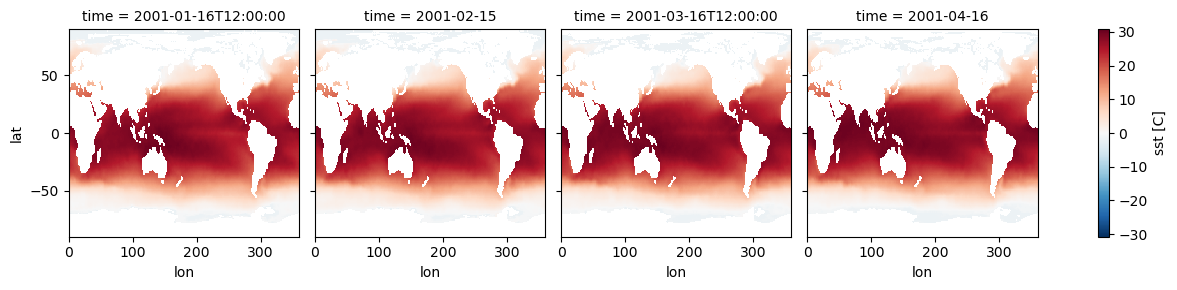

In [80]:
# Faceting
hadisst_ds_slice = hadisst_ds_regrid['tos'].sel(time=slice('2001-01', '2001-04'))
g = hadisst_ds_slice.plot(col="time", col_wrap=4)

### Compare with CMIP models

In [81]:
# merge hadisst dataset with cmip dict
all_dict = cmip_dict.copy()
all_dict["OBS.HAD.HADISST.regrid.nc"] = hadisst_ds_regrid
list(all_dict.keys())

['CMIP.MRI.MRI-ESM2-0.historical.Omon.gn_cellarea.regridded.nc',
 'CMIP.MIROC.MIROC6.historical.Omon.gn_cellarea.regridded.nc',
 'CMIP.BCC.BCC-ESM1.historical.Omon.gn_cellarea.regridded.nc',
 'CMIP.CAS.FGOALS-f3-L.historical.Omon.gn_cellarea.regridded.nc',
 'CMIP.NASA-GISS.GISS-E2-1-G.historical.Omon.gn_cellarea.regridded.nc',
 'OBS.HAD.HADISST.regrid.nc']

## Preprocessing

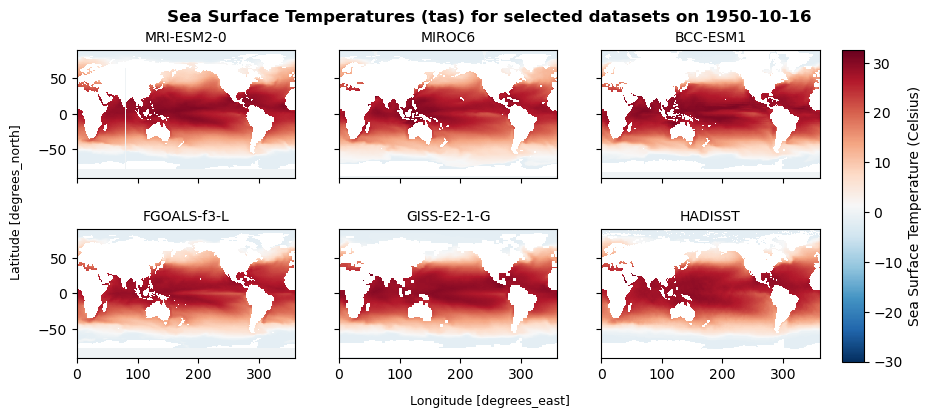

In [82]:
time_sel = "1950-10-16"

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(11, 4), sharex=True, sharey=True)

# get min and max tos values across all datasets for shared color bar
tos_min, tos_max = -30, +30
for (name, ds), ax in zip(all_dict.items(), axs.flat):
    data = ds['tos'].sel(time=time_sel)
    tos_min = min(tos_min, data.min())
    tos_max = max(tos_max, data.max())


# Iterate over datasets and their respective axes
for (name, ds), ax in zip(all_dict.items(), axs.flat):
    data = ds['tos'].sel(time=time_sel)

    im = data.plot(ax=ax, add_colorbar=False, cmap='RdBu_r', vmin=tos_min, vmax=tos_max)
    
    # Set title to the dataset's name
    ax.set_title(name.split(".")[2], fontsize=10)

    # Accessing axis labels
    xlabel = ax.get_xlabel()
    ylabel = ax.get_ylabel()
    ax.set(xlabel=None, ylabel=None)

    

# Set title
fig.suptitle(f"Sea Surface Temperatures (tas) for selected datasets on {time_sel}", fontweight="bold")

# Create a shared colorbar for the entire figure
fig.subplots_adjust(right=0.8, hspace=0.4) # Adjust spacing between subplots, as well as right margin for the colorbar
cbar_ax = fig.add_axes([0.82, 0.10, 0.02, 0.78])
cbar = fig.colorbar(im, cax=cbar_ax)
cbar.set_label('Sea Surface Temperature (Celsius)')  


fig.text(0.5, 0.0, xlabel, ha='center', va='center', fontsize=9)
fig.text(0.07, 0.5, ylabel, ha='center', va='center', rotation='vertical', fontsize=9)

plt.show()

### Compute and Plot Temperature Anomalies


1. Compute Climatology - Monthly Gridded Climate Normals: For every spatial coordinate, compute the monthly mean SST over the time period of {BASE_PERIOD_START_yr}-{BASE_PERIOD_END_yr}.

2. Compute the tos anomalies subtract this mean from all data of the same month

[(tutorial)](https://comptools.climatematch.io/tutorials/W1D1_ClimateSystemOverview/student/W1D1_Tutorial6.html)

#### Compute SST Monthly Climatology

In [83]:
print(f"Computing SST monthly climatology for HadISST over the period of {BASE_PERIOD_START_yr} to {BASE_PERIOD_END_yr}")

# compute SST monthly climatology for the period of {BASE_PERIOD_START_yr} to {BASE_PERIOD_END_yr}
hadisst_climatology = hadisst_ds_regrid['tos'].sel(time=slice(BASE_PERIOD_START, BASE_PERIOD_END)).groupby("time.month").mean("time")
# display(hadisst_climatology)

# Assign the tos anomaly DataArray to a new Dataset
hadisst_climatology_ds = hadisst_climatology.to_dataset(name='sst_climatology') 
hadisst_climatology_ds

Computing SST monthly climatology for HadISST over the period of 1961 to 1990


<xarray.Dataset> Size: 3MB
Dimensions:          (lat: 180, lon: 360, month: 12)
Coordinates:
  * lat              (lat) float64 1kB -89.5 -88.5 -87.5 ... 87.5 88.5 89.5
  * lon              (lon) float64 3kB 0.5 1.5 2.5 3.5 ... 357.5 358.5 359.5
  * month            (month) int64 96B 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    sst_climatology  (month, lat, lon) float32 3MB nan nan nan ... nan nan nan

#### Plot monthly climatology per month for HadISST

##### Full map

Minimum temperature: -1.80°C
Maximum temperature: 33.08°C


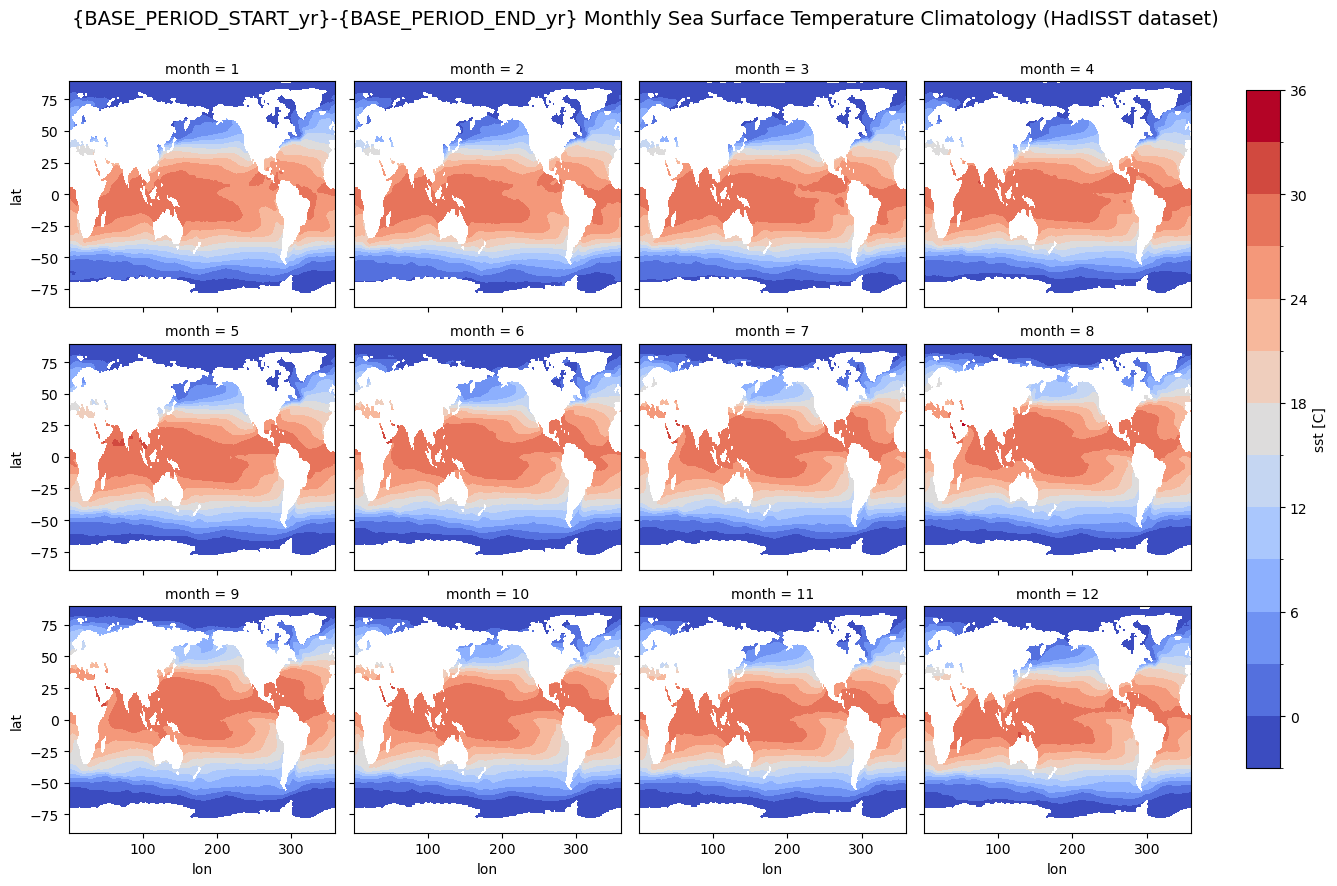

In [84]:
# Faceting with xarray
hadisst_min = hadisst_climatology_ds['sst_climatology'].min().values
hadisst_max = hadisst_climatology_ds['sst_climatology'].max().values

print(f'Minimum temperature: {hadisst_min:.2f}°C')
print(f'Maximum temperature: {hadisst_max:.2f}°C')

# g = hadisst_climatology_ds['sst_climatology'].plot(
#     x="longitude", y="latitude", col="month", col_wrap=4, 
#     vmin=hadisst_min, vmax=hadisst_max, cmap=plt.cm.coolwarm,
#     cbar_kwargs={'fraction': 0.028}
# )

# define contour levels in 3 degree increments
contour_levels = np.arange(np.floor(hadisst_min)-1, hadisst_max + 3, 3)
# print(contour_levels)

# contour plot
g = hadisst_climatology_ds['sst_climatology'].plot.contourf(
    col="month", col_wrap=4, 
    levels=contour_levels,
    cmap=plt.cm.coolwarm,
    cbar_kwargs={'fraction': 0.028}
)
g.set_titles(template='{coord} = {value}')
g.fig.suptitle('{BASE_PERIOD_START_yr}-{BASE_PERIOD_END_yr} Monthly Sea Surface Temperature Climatology (HadISST dataset)', fontsize=14)
g.fig.subplots_adjust(right=0.92, top=0.9, wspace=None, hspace=None)  # Adjust the top margin to make space for the title

##### Zoom in

Minimum temperature: -1.80°C
Maximum temperature: 33.08°C


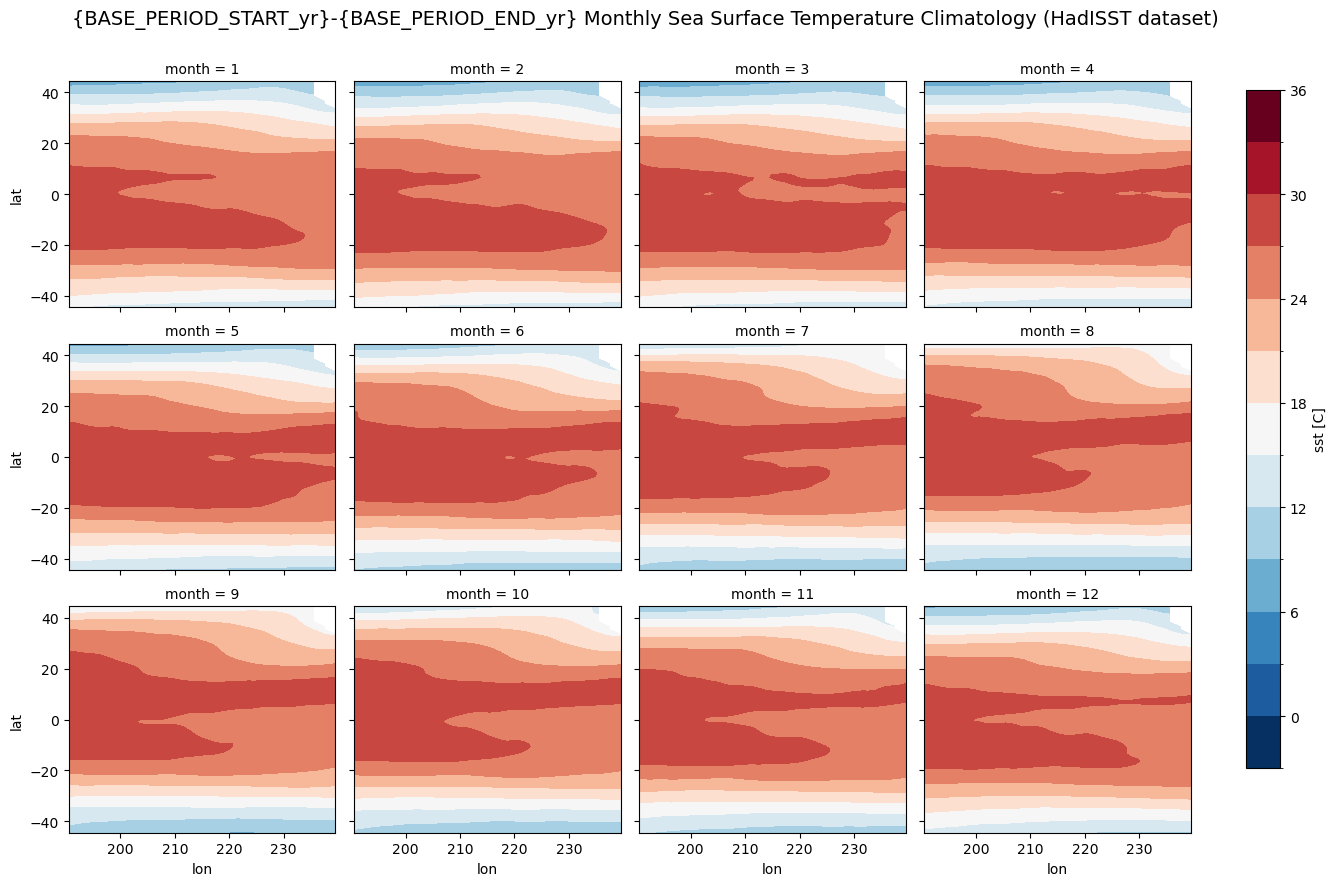

In [85]:
nino34_min_lat, nino34_max_lat = -45, 45
nino34_min_lon, nino34_max_lon = 190, 240


# Faceting with xarray
hadisst_min = hadisst_climatology_ds['sst_climatology'].min().values
hadisst_max = hadisst_climatology_ds['sst_climatology'].max().values

print(f'Minimum temperature: {hadisst_min:.2f}°C')
print(f'Maximum temperature: {hadisst_max:.2f}°C')

# define contour levels in 3 degree increments
contour_levels = np.arange(np.floor(hadisst_min)-1, hadisst_max + 3, 3)

# contour plot
g = hadisst_climatology_ds['sst_climatology'].sel(lat=slice(nino34_min_lat, nino34_max_lat),
                                                  lon=slice(nino34_min_lon, nino34_max_lon)).plot.contourf(
    col="month", col_wrap=4, 
    levels=contour_levels,
    # cmap=plt.cm.coolwarm,
    cbar_kwargs={'fraction': 0.028},
)

g.set_titles(template='{coord} = {value}')
g.fig.suptitle('{BASE_PERIOD_START_yr}-{BASE_PERIOD_END_yr} Monthly Sea Surface Temperature Climatology (HadISST dataset)', fontsize=14)
g.fig.subplots_adjust(right=0.92, top=0.9, wspace=None, hspace=None)  # Adjust the top margin to make space for the title